In [1]:
# from __future__ import division
import itertools

# To get rid of those blocks of red warnings
import warnings
warnings.filterwarnings("ignore")

# Standard Imports
import numpy as np
from scipy import stats
import pandas as pd
from math import sqrt
import os
from scipy.stats import spearmanr
from sklearn import metrics
from random import randint


# Vis Imports
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import plotly.express as px
from pandas.plotting import register_matplotlib_converters
from mpl_toolkits.mplot3d import Axes3D
from wordcloud import WordCloud
from PIL import Image

# Modeling Imports
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import f_regression 
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression, RFE
import sklearn.preprocessing
import statsmodels.api as sm
from sklearn.cluster import DBSCAN
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import MiniBatchKMeans, KMeans

# NLP Imports
import unicodedata
import re
import json
import requests
from bs4 import BeautifulSoup
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords

# Custom Module Imports
import model

In [2]:
original = pd.read_csv('mbti_1.csv')

In [3]:
original.head()

type                                              posts
0  INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1  ENTP  'I'm finding the lack of me in these posts ver...
2  INTP  'Good one  _____   https://www.youtube.com/wat...
3  INTJ  'Dear INTP,   I enjoyed our conversation the o...
4  ENTJ  'You're fired.|||That's another silly misconce...

In [4]:
def basic_clean(original):
    article = original.lower()
    article = unicodedata.normalize('NFKD', article)\
    .encode('ascii', 'ignore')\
    .decode('utf-8')
    #use re.sub to remove special characters
    article = re.sub(r'[^a-z\s]', '', article)
#   article = re.sub(r'[a-z]{20,}', '', article)
#   article = re.sub(r'\s+', ' ', article)
    return article

def tokenize(article):
    #create the tokenizer
    tokenize = nltk.tokenize.ToktokTokenizer()
    #use the tokenizer
    article = tokenize.tokenize(article, return_str=True)
    return article

def stem(article):
    #create porter stemmer
    ps = nltk.porter.PorterStemmer()
    stems = [ps.stem(word) for word in article.split()]
    #join words back together
    article_stemmed = ' '.join(stems)
    return article_stemmed

def lemmatize(article):
    #create the lemmatizer
    wnl = nltk.stem.WordNetLemmatizer()
    lemmas = [wnl.lemmatize(word) for word in article.split()]
    #join words back together
    article_lemmatized = ' '.join(lemmas)
    return article_lemmatized

more_stopwords = ['like', 'im', 'think', 'dont', 'people', 'know', 'one', 'get', 'really', 'thing',
                  'would', 'time', 'type', 'make', 'friend', 'ive', 'feel', 'much', 'love',
                 'say', 'way', 'see', 'thing', 'want', 'thing', 'good', 'something', 'lot',
                  'also', 'go', 'always', 'even', 'well', 'someone', 'co', 'thing', 'https',
                  'could', 'year', 'cant', 'w', 'sent', 'iphone']

def remove_stopwords(article):
    #save stopwords
    stopwords_ls = stopwords.words('english', 'spanish') + more_stopwords
    words = article.split()
    #remove stopwords from list of words
    filtered_words = [word for word in words if word not in stopwords_ls]
    #join words back together
    article = ' '.join(filtered_words)
    return article

In [5]:
def prepare_article(original):
    original['stemmed'] = original['posts'].apply(basic_clean).apply(tokenize).apply(remove_stopwords).apply(stem)
    original['lemmatized'] = original['posts'].apply(basic_clean).apply(tokenize).apply(remove_stopwords).apply(lemmatize)
    original.rename(columns = {'posts':'original'}, inplace = True)
    return original

In [6]:
df0 = prepare_article(original)

In [7]:
df0.head()

type                                           original  \
0  INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...   
1  ENTP  'I'm finding the lack of me in these posts ver...   
2  INTP  'Good one  _____   https://www.youtube.com/wat...   
3  INTJ  'Dear INTP,   I enjoyed our conversation the o...   
4  ENTJ  'You're fired.|||That's another silly misconce...   

                                             stemmed  \
0  httpwwwyoutubecomwatchvqsxhcwekrwhttpmediatumb...   
1  find lack post alarmingsex bore posit often ex...   
2  httpswwwyoutubecomwatchvfhigbolffgwof cours th...   
3  dear intp enjoy convers day esoter gab natur u...   
4  your firedthat anoth silli misconcept approach...   

                                          lemmatized  
0  httpwwwyoutubecomwatchvqsxhcwekrwhttpmediatumb...  
1  finding lack post alarmingsex boring position ...  
2  httpswwwyoutubecomwatchvfhigbolffgwof course t...  
3  dear intp enjoyed conversation day esoteric ga...  
4  youre firedthats another silly misconception a...

In [8]:
df1 = pd.read_pickle('maindalemma.pkl')

In [9]:
df1.head()

type                 name  \
0  ENTP  neil patrick harris   
1  ENTP        conan o'brien   
2  ENTP       shah rukh khan   
3  ENTP           kanye west   
4  ENTP          stephen fry   

                                        stoped_lemma  \
0  tomorrow year cheers us youve yet signed weekl...   
1  hear geek guitars men today day year grateful ...   
2  front foot shot sports ways hoping pave others...   
3  iranian youth leading years world needs suppor...   
4  pig vomit toxin key martian mystery bbc news n...   

                                                freq  
0  {'sign': 22, 'gt': 16, 'free': 15, 'issue': 14...  
1  {'hear': 10, 'fan': 7, 'chat': 6, 'please': 5,...  
2  {'amp': 20, 'pathaan': 19, 'back': 10, 'toh': ...  
3  {'god': 12, 'kanye': 10, 'nah': 6, 'world': 6,...  
4  {'oh': 11, 'new': 9, 'ever': 7, 'party': 6, 'a...

In [10]:
df1['lemmatized'] = df1['stoped_lemma']
df1 = df1[['type', 'lemmatized']]

In [11]:
df1.head()

type                                         lemmatized
0  ENTP  tomorrow year cheers us youve yet signed weekl...
1  ENTP  hear geek guitars men today day year grateful ...
2  ENTP  front foot shot sports ways hoping pave others...
3  ENTP  iranian youth leading years world needs suppor...
4  ENTP  pig vomit toxin key martian mystery bbc news n...

In [12]:
df1['lemmatized'] = df1['lemmatized'].apply(remove_stopwords)

In [13]:
df1.head()

type                                         lemmatized
0  ENTP  tomorrow cheers us youve yet signed weekly the...
1  ENTP  hear geek guitars men today day grateful born ...
2  ENTP  front foot shot sports ways hoping pave others...
3  ENTP  iranian youth leading years world needs suppor...
4  ENTP  pig vomit toxin key martian mystery bbc news n...

In [14]:
df0 = df0[['type', 'lemmatized']]

In [15]:
df0.head()

type                                         lemmatized
0  INFJ  httpwwwyoutubecomwatchvqsxhcwekrwhttpmediatumb...
1  ENTP  finding lack post alarmingsex boring position ...
2  INTP  httpswwwyoutubecomwatchvfhigbolffgwof course t...
3  INTJ  dear intp enjoyed conversation day esoteric ga...
4  ENTJ  youre firedthats another silly misconception a...

In [16]:
df = pd.concat([df0, df1])


In [17]:
df.shape

(9274, 2)

In [18]:
df['I_E'] = df['type'].astype(str).str[0]
df['N_S'] = df['type'].astype(str).str[1]
df['T_F'] = df['type'].astype(str).str[2]
df['J_P'] = df['type'].astype(str).str[3]

In [19]:
#defining function filter 
def filter(x):
    if x == 'INTJ' or x == 'INTP' or x == 'ENTJ' or x == 'ENTP':
        return 'Analyst'
    if x == 'INFJ' or x == 'INFP' or x == 'ENFJ' or x == 'ENFP':
        return 'Diplomat'
    if x == 'ISTJ' or x == 'ISFJ' or x == 'ESTJ' or x == 'ESFJ':
        return 'Sentinel'
    if x == 'ISTP' or x == 'ISFP' or x == 'ESTP' or x == 'ESFP':
        return 'Explorer'

In [20]:
#applying the filter function to 'year_built' column 
df['personality_domain'] = df['type'].apply(filter)

In [21]:
df.head()

type                                         lemmatized I_E N_S T_F J_P  \
0  INFJ  httpwwwyoutubecomwatchvqsxhcwekrwhttpmediatumb...   I   N   F   J   
1  ENTP  finding lack post alarmingsex boring position ...   E   N   T   P   
2  INTP  httpswwwyoutubecomwatchvfhigbolffgwof course t...   I   N   T   P   
3  INTJ  dear intp enjoyed conversation day esoteric ga...   I   N   T   J   
4  ENTJ  youre firedthats another silly misconception a...   E   N   T   J   

  personality_domain  
0           Diplomat  
1            Analyst  
2            Analyst  
3            Analyst  
4            Analyst

In [22]:
df = df[['type', 'personality_domain', 'I_E', 'N_S', 'T_F', 'J_P', 'lemmatized']]


In [23]:
df.head()

type personality_domain I_E N_S T_F J_P  \
0  INFJ           Diplomat   I   N   F   J   
1  ENTP            Analyst   E   N   T   P   
2  INTP            Analyst   I   N   T   P   
3  INTJ            Analyst   I   N   T   J   
4  ENTJ            Analyst   E   N   T   J   

                                          lemmatized  
0  httpwwwyoutubecomwatchvqsxhcwekrwhttpmediatumb...  
1  finding lack post alarmingsex boring position ...  
2  httpswwwyoutubecomwatchvfhigbolffgwof course t...  
3  dear intp enjoyed conversation day esoteric ga...  
4  youre firedthats another silly misconception a...

### Rows count and percent by personality type

In [24]:
labels = pd.concat([df.type.value_counts(),
                    df.type.value_counts(normalize=True)], axis=1)
labels.columns = ['n', 'percent']
labels

n   percent
INFP  1847  0.199159
INFJ  1497  0.161419
INTP  1315  0.141794
INTJ  1102  0.118827
ENTP   736  0.079362
ENFP   735  0.079254
ISTP   367  0.039573
ISFP   320  0.034505
ENTJ   253  0.027281
ENFJ   227  0.024477
ISTJ   217  0.023399
ISFJ   198  0.021350
ESFP   151  0.016282
ESTP   139  0.014988
ESFJ   108  0.011645
ESTJ    62  0.006685

In [25]:
# 60/20/20 Train, Validate, Test split
train_val, test = train_test_split(df, stratify=df.type, test_size=.2, random_state=123)
train, validate = train_test_split(train_val, stratify=train_val.type, test_size=.25, random_state=123)

In [26]:
INFP_words = (' '.join(train[train.type == 'INFP'].lemmatized)).split()
INFJ_words = (' '.join(train[train.type == 'INFJ'].lemmatized)).split()
INTP_words = (' '.join(train[train.type == 'INTP'].lemmatized)).split()
INTJ_words = (' '.join(train[train.type == 'INTJ'].lemmatized)).split()
ENTP_words = (' '.join(train[train.type == 'ENTP'].lemmatized)).split()
ENFP_words = (' '.join(train[train.type == 'ENFP'].lemmatized)).split()
ISTP_words = (' '.join(train[train.type == 'ISTP'].lemmatized)).split()
ISFP_words = (' '.join(train[train.type == 'ISFP'].lemmatized)).split()
ENTJ_words = (' '.join(train[train.type == 'ENTJ'].lemmatized)).split()
ISTJ_words = (' '.join(train[train.type == 'ISTJ'].lemmatized)).split()
ENFJ_words = (' '.join(train[train.type == 'ENFJ'].lemmatized)).split()
ISFJ_words = (' '.join(train[train.type == 'ISFJ'].lemmatized)).split()
ESTP_words = (' '.join(train[train.type == 'ESTP'].lemmatized)).split()
ESFP_words = (' '.join(train[train.type == 'ESFP'].lemmatized)).split()
ESFJ_words = (' '.join(train[train.type == 'ESFJ'].lemmatized)).split()
ESTJ_words = (' '.join(train[train.type == 'ESTJ'].lemmatized)).split()
all_words = (' '.join(train.lemmatized)).split()

In [27]:
E_words = (' '.join(train[train.I_E == 'E'].lemmatized)).split()
I_words = (' '.join(train[train.I_E == 'I'].lemmatized)).split()
E_freq = pd.Series(E_words).value_counts()
I_freq = pd.Series(I_words).value_counts()

In [28]:
INFP_freq = pd.Series(INFP_words).value_counts()
INFJ_freq = pd.Series(INFJ_words).value_counts()
INTP_freq = pd.Series(INTP_words).value_counts()
INTJ_freq = pd.Series(INTJ_words).value_counts()
ENTP_freq = pd.Series(ENTP_words).value_counts()
ENFP_freq = pd.Series(ENFP_words).value_counts()
ISTP_freq = pd.Series(ISTP_words).value_counts()
ISFP_freq = pd.Series(ISFP_words).value_counts()
ENTJ_freq = pd.Series(ENTJ_words).value_counts()
ISTJ_freq = pd.Series(ISTJ_words).value_counts()
ENFJ_freq = pd.Series(ENFJ_words).value_counts()
ISFJ_freq = pd.Series(ISFJ_words).value_counts()
ESTP_freq = pd.Series(ESTP_words).value_counts()
ESFP_freq = pd.Series(ESFP_words).value_counts()
ESFJ_freq = pd.Series(ESFJ_words).value_counts()
ESTJ_freq = pd.Series(ESTJ_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

In [29]:
freq_list = [all_freq, INFP_freq, INFJ_freq, INTP_freq, INTJ_freq, ENTP_freq, ENFP_freq, ISTP_freq, ISFP_freq,
 ENTJ_freq, ISTJ_freq, ENFJ_freq, ISFJ_freq, ESTP_freq, ESFP_freq, ESFJ_freq, ESTJ_freq]

In [30]:
for x in freq_list:
    print(x.head())

thing    11773
life      9698
never     9007
youre     8883
find      8687
dtype: int64
infp     3425
thing    2597
life     2279
never    1990
find     1808
dtype: int64
infj     2991
thing    2102
life     1934
youre    1554
find     1538
dtype: int64
intp     2225
thing    1630
never    1324
find     1276
youre    1231
dtype: int64
intj     2255
thing    1304
find     1109
never    1044
intjs    1015
dtype: int64
entp     1375
thing     865
youre     851
never     724
entps     664
dtype: int64
enfp     1569
thing     997
life      787
youre     765
thats     756
dtype: int64
istp     503
need     406
thing    405
work     372
youre    355
dtype: int64
isfp     578
thing    381
life     316
thank    282
find     274
dtype: int64
entj     504
thing    284
life     270
find     252
youre    251
dtype: int64
istj     425
thing    293
work     268
never    209
going    204
dtype: int64
enfj     419
thing    297
need     275
life     261
youre    255
dtype: int64
isfj     414
thing    36

In [31]:
E_freq.head(10)

thing    2701
youre    2410
life     2399
enfp     2173
never    2147
thats    2141
need     2114
find     2024
going    1998
new      1968
dtype: int64

In [32]:
I_freq.head(10)

thing      9072
life       7299
never      6860
find       6663
youre      6473
thought    6187
though     6185
need       6105
going      5818
thats      5763
dtype: int64

In [33]:
word_counts = (pd.concat([all_freq, INFP_freq, INFJ_freq, INTP_freq, INTJ_freq, ENTP_freq, ENFP_freq, ISTP_freq,
                        ISFP_freq, ENTJ_freq, ISTJ_freq, ENFJ_freq, ISFJ_freq, ESTP_freq, ESFP_freq, ESFJ_freq, ESTJ_freq], axis=1, sort=True)
                .set_axis(['all', 'INFP', 'INFJ', 'INTP', 'INTJ', 'ENTP', 'ENFP', 'ISTP', 'ISFP',
                          'ENTJ', 'ISTJ', 'ENFJ', 'ISFJ', 'ESTP', 'ESFP', 'ESFJ', 'ESTJ'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

word_counts.head()

all  INFP  INFJ  INTP  INTJ  ENTP  ENFP  ISTP  ISFP  ENTJ  ISTJ  \
aa           67    14     9     3    10     4    11     2     1     0     4   
aaa           4     2     0     0     0     1     0     0     0     0     0   
aaaa          1     0     0     0     0     0     0     0     0     0     0   
aaaaaaaaa     1     0     0     0     0     0     0     0     1     0     0   
aaaaaaaaaa    1     0     0     0     0     0     1     0     0     0     0   

            ENFJ  ISFJ  ESTP  ESFP  ESFJ  ESTJ  
aa             2     3     0     0     4     0  
aaa            0     0     0     0     1     0  
aaaa           0     0     0     0     1     0  
aaaaaaaaa      0     0     0     0     0     0  
aaaaaaaaaa     0     0     0     0     0     0

### What are the most frequently occuring words?

In [34]:
word_counts.sort_values(by='all', ascending=False).head(10)

all  INFP  INFJ  INTP  INTJ  ENTP  ENFP  ISTP  ISFP  ENTJ  ISTJ  \
thing    11773  2597  2102  1630  1304   865   997   405   381   284   293   
life      9698  2279  1934  1153   954   641   787   277   316   270   171   
never     9007  1990  1526  1324  1044   724   659   335   255   198   209   
youre     8883  1713  1554  1231   989   851   765   355   248   251   165   
find      8687  1808  1538  1276  1109   658   642   292   274   252   193   
need      8219  1583  1398  1187   944   601   673   406   219   233   175   
thought   8028  1763  1479  1180   964   635   658   244   238   183   162   
though    7935  1771  1423  1170   870   581   644   292   269   178   201   
thats     7904  1612  1316  1079   875   660   756   310   246   221   167   
going     7816  1676  1264  1016   933   581   630   300   231   209   204   

         ENFJ  ISFJ  ESTP  ESFP  ESFJ  ESTJ  
thing     297   360    94    36    62    66  
life      261   215   160   103    96    81  
never     210   177   115    92    70    79  
youre     255   218   113    86    55    34  
find      215   173    69    69    69    50  
need      275   193    99   110    55    68  
thought   188   157    79    42    30    26  
though    151   189    63    45    62    26  
thats     220   158   106    85    58    35  
going     222   194   117    97    78    64

In [35]:
all_cloud = WordCloud(background_color='white', height=1000, width=400).generate(' '.join(all_words))
INFP_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(INFP_words))
INFJ_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(INFJ_words))
INTP_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(INTP_words))
INTJ_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(INTJ_words))
ENTP_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(ENTP_words))
ENFP_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(ENFP_words))
ISTP_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(ISTP_words))
ISFP_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(ISFP_words))
ENTJ_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(ENTJ_words))
ISTJ_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(ISTJ_words))
ENFJ_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(ENFJ_words))
ISFJ_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(ISFJ_words))
ESTP_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(ESTP_words))
ESFP_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(ESFP_words))
ESFJ_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(ESFJ_words))
ESTJ_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(ESTJ_words))


In [36]:
# Importing mask
from PIL import Image

twitter_mask = np.array(Image.open("./Twitter.png"))


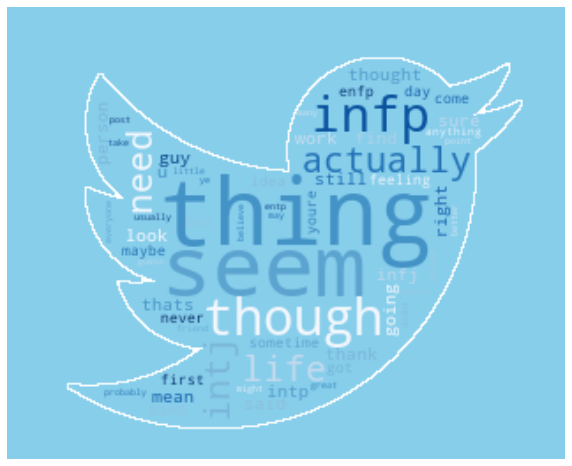

In [37]:
# Plot the wordcloud with the mask applied
wc = WordCloud(background_color='skyblue', mask= twitter_mask, colormap = 'Blues',
               contour_color='white', contour_width=1).generate(' '.join(all_words))
plt.figure(figsize=[10,10])
plt.tight_layout()
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

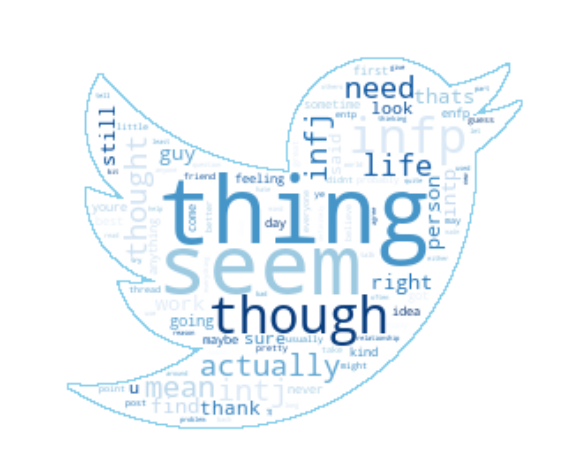

In [38]:
# Plot the wordcloud with the mask applied
wc = WordCloud(background_color='white', mask= twitter_mask, colormap = 'Blues',
               contour_color='skyblue', contour_width=1).generate(' '.join(all_words))
plt.figure(figsize=[10,10])
plt.tight_layout()
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

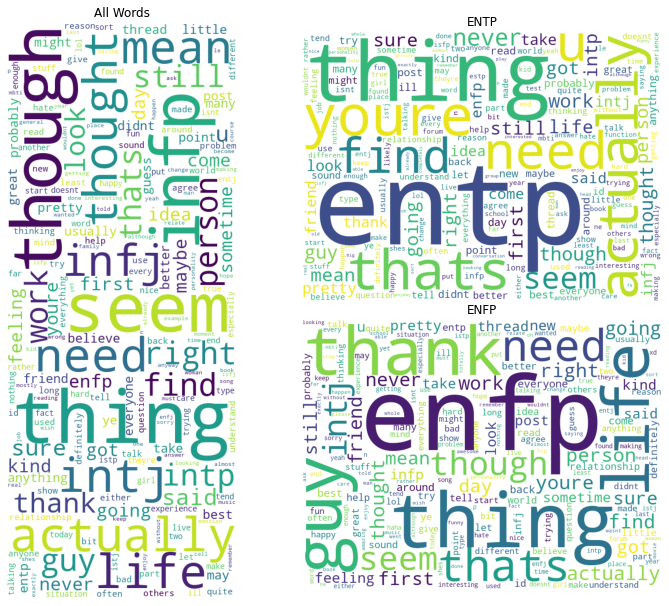

In [39]:
plt.figure(figsize=(10, 8))
axs = [plt.axes([0, 0, .5, 1]), plt.axes([.5, .5, .5, .5]), plt.axes([.5, 0, .5, .5])]

axs[0].imshow(all_cloud)
axs[1].imshow(ENTP_cloud)
axs[2].imshow(ENFP_cloud)

axs[0].set_title('All Words')
axs[1].set_title('ENTP')
axs[2].set_title('ENFP')

for ax in axs: ax.axis('off')

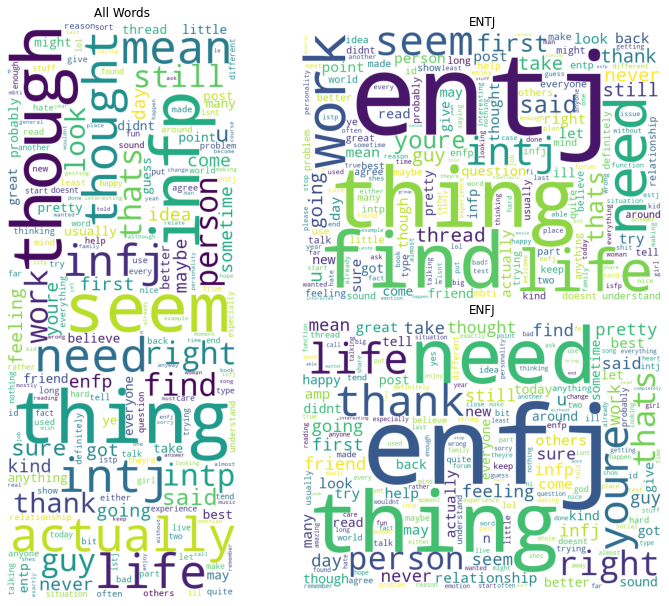

In [40]:
plt.figure(figsize=(10, 8))
axs = [plt.axes([0, 0, .5, 1]), plt.axes([.5, .5, .5, .5]), plt.axes([.5, 0, .5, .5])]

axs[0].imshow(all_cloud)
axs[1].imshow(ENTJ_cloud)
axs[2].imshow(ENFJ_cloud)

axs[0].set_title('All Words')
axs[1].set_title('ENTJ')
axs[2].set_title('ENFJ')

for ax in axs: ax.axis('off')

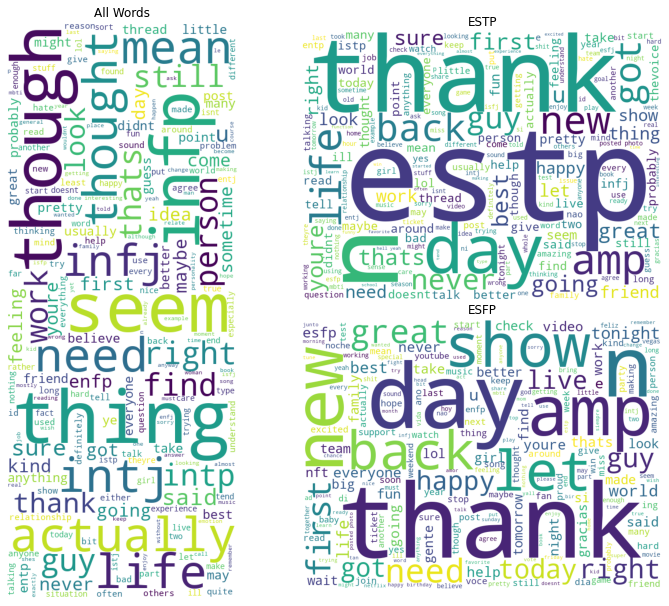

In [41]:
plt.figure(figsize=(10, 8))
axs = [plt.axes([0, 0, .5, 1]), plt.axes([.5, .5, .5, .5]), plt.axes([.5, 0, .5, .5])]

axs[0].imshow(all_cloud)
axs[1].imshow(ESTP_cloud)
axs[2].imshow(ESFP_cloud)

axs[0].set_title('All Words')
axs[1].set_title('ESTP')
axs[2].set_title('ESFP')

for ax in axs: ax.axis('off')

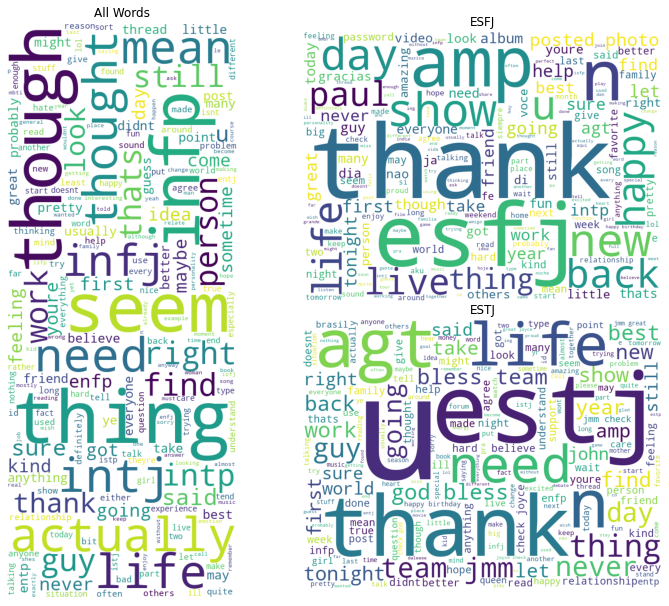

In [42]:
plt.figure(figsize=(10, 8))
axs = [plt.axes([0, 0, .5, 1]), plt.axes([.5, .5, .5, .5]), plt.axes([.5, 0, .5, .5])]

axs[0].imshow(all_cloud)
axs[1].imshow(ESFJ_cloud)
axs[2].imshow(ESTJ_cloud)

axs[0].set_title('All Words')
axs[1].set_title('ESFJ')
axs[2].set_title('ESTJ')

for ax in axs: ax.axis('off')

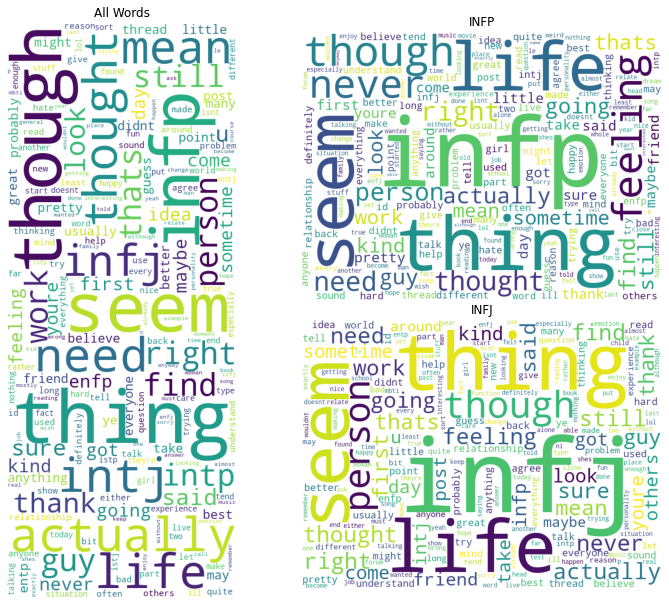

In [43]:
plt.figure(figsize=(10, 8))
axs = [plt.axes([0, 0, .5, 1]), plt.axes([.5, .5, .5, .5]), plt.axes([.5, 0, .5, .5])]

axs[0].imshow(all_cloud)
axs[1].imshow(INFP_cloud)
axs[2].imshow(INFJ_cloud)

axs[0].set_title('All Words')
axs[1].set_title('INFP')
axs[2].set_title('INFJ')

for ax in axs: ax.axis('off')

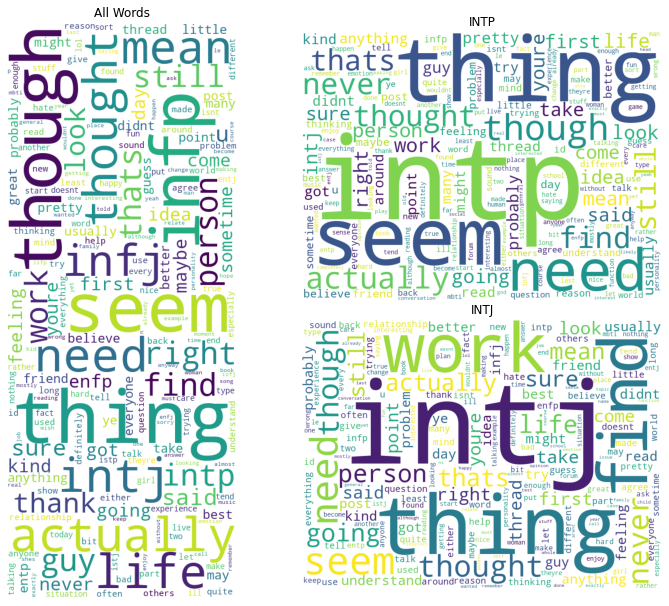

In [44]:
plt.figure(figsize=(10, 8))
axs = [plt.axes([0, 0, .5, 1]), plt.axes([.5, .5, .5, .5]), plt.axes([.5, 0, .5, .5])]

axs[0].imshow(all_cloud)
axs[1].imshow(INTP_cloud)
axs[2].imshow(INTJ_cloud)

axs[0].set_title('All Words')
axs[1].set_title('INTP')
axs[2].set_title('INTJ')

for ax in axs: ax.axis('off')

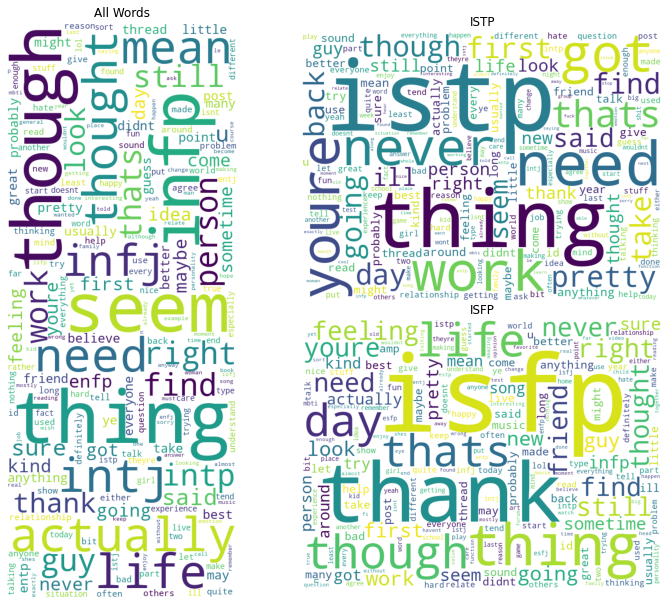

In [45]:
plt.figure(figsize=(10, 8))
axs = [plt.axes([0, 0, .5, 1]), plt.axes([.5, .5, .5, .5]), plt.axes([.5, 0, .5, .5])]

axs[0].imshow(all_cloud)
axs[1].imshow(ISTP_cloud)
axs[2].imshow(ISFP_cloud)

axs[0].set_title('All Words')
axs[1].set_title('ISTP')
axs[2].set_title('ISFP')

for ax in axs: ax.axis('off')

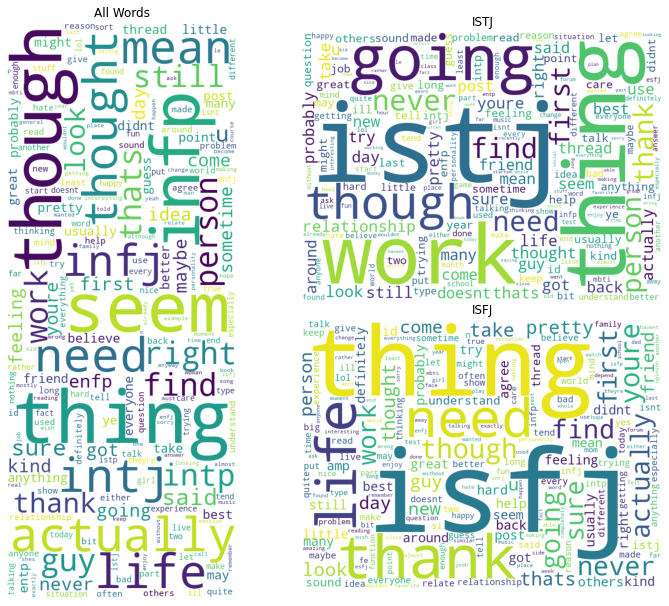

In [46]:
plt.figure(figsize=(10, 8))
axs = [plt.axes([0, 0, .5, 1]), plt.axes([.5, .5, .5, .5]), plt.axes([.5, 0, .5, .5])]

axs[0].imshow(all_cloud)
axs[1].imshow(ISTJ_cloud)
axs[2].imshow(ISFJ_cloud)

axs[0].set_title('All Words')
axs[1].set_title('ISTJ')
axs[2].set_title('ISFJ')

for ax in axs: ax.axis('off')

In [47]:
# all_words
# INFP_words
# INFJ_words
# INTP_words
# INTJ_words
# ENTP_words
# ENFP_words
# ISTP_words
# ISFP_words
# ENTJ_words
# ISTJ_words
# ENFJ_words
# ISFJ_words
# ESTP_words
# ESFP_words
# ESFJ_words
# ESTJ_words

In [48]:
top_20_all_words_bigrams = (pd.Series(nltk.ngrams(all_words, 2))
                      .value_counts()
                      .head(20))
top_20_INFP_words_bigrams = (pd.Series(nltk.ngrams(INFP_words, 2))
                      .value_counts()
                      .head(20))
top_20_INFJ_words_bigrams = (pd.Series(nltk.ngrams(INFJ_words, 2))
                      .value_counts()
                      .head(20))
top_20_INTP_words_bigrams = (pd.Series(nltk.ngrams(INTP_words, 2))
                      .value_counts()
                      .head(20))
top_20_INTJ_words_bigrams = (pd.Series(nltk.ngrams(INTJ_words, 2))
                      .value_counts()
                      .head(20))
top_20_ENTP_words_bigrams = (pd.Series(nltk.ngrams(ENTP_words, 2))
                      .value_counts()
                      .head(20))
top_20_ENFP_words_bigrams = (pd.Series(nltk.ngrams(ENFP_words, 2))
                      .value_counts()
                      .head(20))
top_20_ISTP_words_bigrams = (pd.Series(nltk.ngrams(ISTP_words, 2))
                      .value_counts()
                      .head(20))
top_20_ISFP_words_bigrams = (pd.Series(nltk.ngrams(ISFP_words, 2))
                      .value_counts()
                      .head(20))
top_20_ENTJ_words_bigrams = (pd.Series(nltk.ngrams(ENTJ_words, 2))
                      .value_counts()
                      .head(20))
top_20_ISTJ_words_bigrams = (pd.Series(nltk.ngrams(ISTJ_words, 2))
                      .value_counts()
                      .head(20))
top_20_ENFJ_words_bigrams = (pd.Series(nltk.ngrams(ENFJ_words, 2))
                      .value_counts()
                      .head(20))
top_20_ISFJ_words_bigrams = (pd.Series(nltk.ngrams(ISFJ_words, 2))
                      .value_counts()
                      .head(20))
top_20_ESTP_words_bigrams = (pd.Series(nltk.ngrams(ESTP_words, 2))
                      .value_counts()
                      .head(20))
top_20_ESFP_words_bigrams = (pd.Series(nltk.ngrams(ESFP_words, 2))
                      .value_counts()
                      .head(20))
top_20_ESFJ_words_bigrams = (pd.Series(nltk.ngrams(ESFJ_words, 2))
                      .value_counts()
                      .head(20))
top_20_ESTJ_words_bigrams = (pd.Series(nltk.ngrams(ESTJ_words, 2))
                      .value_counts()
                      .head(20))

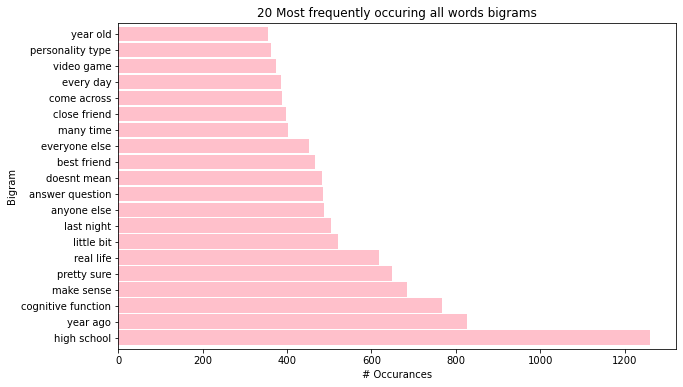

In [49]:
top_20_all_words_bigrams.sort_values(ascending=False).plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring all words bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_all_words_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

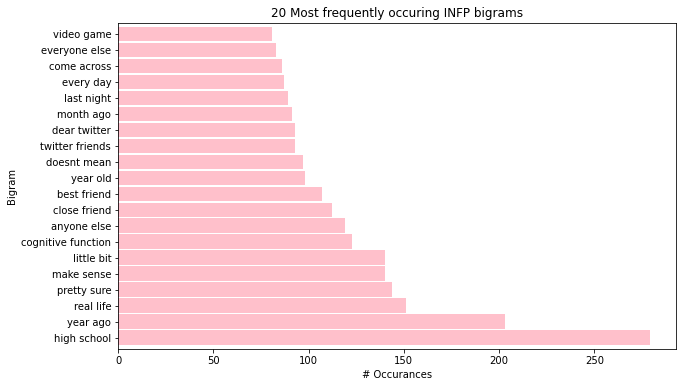

In [50]:
top_20_INFP_words_bigrams.sort_values(ascending=False).plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring INFP bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_INFP_words_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

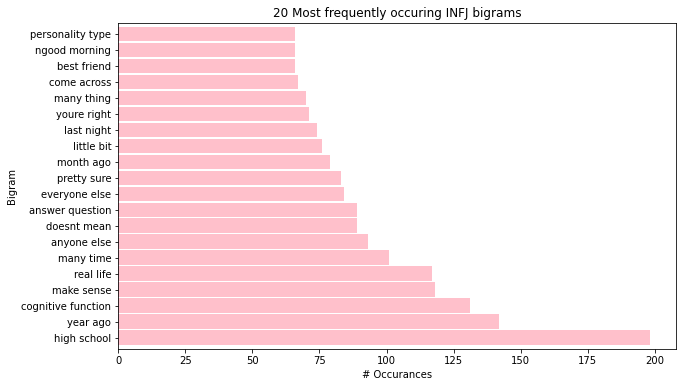

In [51]:
top_20_INFJ_words_bigrams.sort_values(ascending=False).plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring INFJ bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_INFJ_words_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

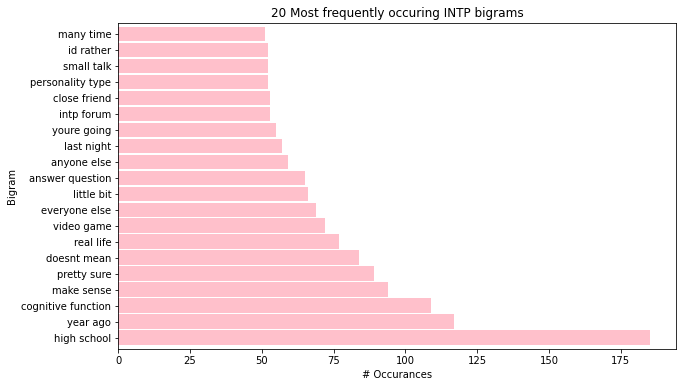

In [52]:
top_20_INTP_words_bigrams.sort_values(ascending=False).plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring INTP bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_INTP_words_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

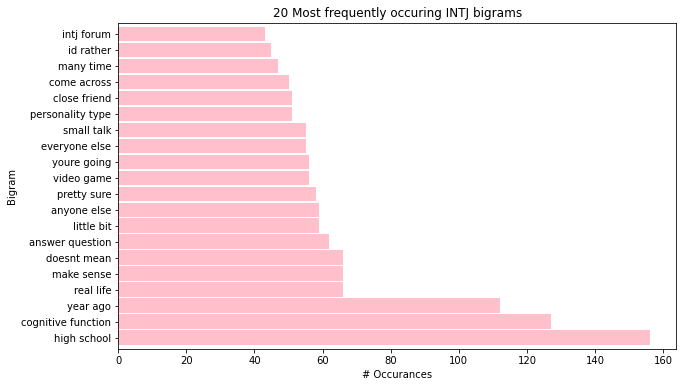

In [53]:
top_20_INTJ_words_bigrams.sort_values(ascending=False).plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring INTJ bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_INTJ_words_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

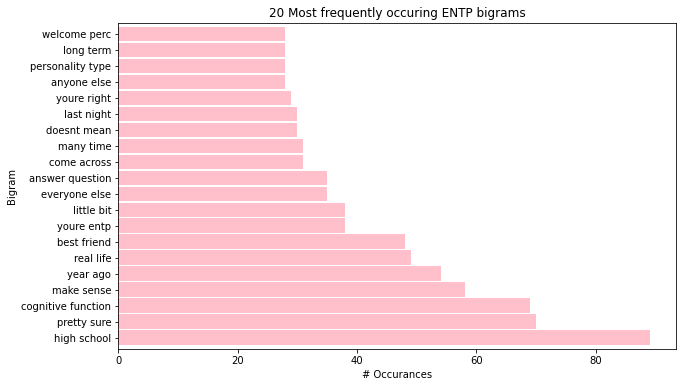

In [54]:
top_20_ENTP_words_bigrams.sort_values(ascending=False).plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring ENTP bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_ENTP_words_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

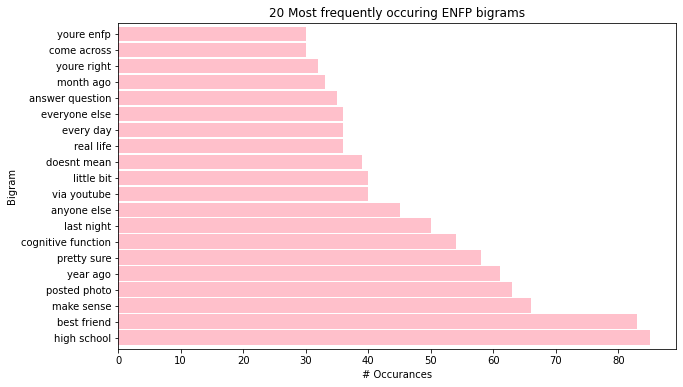

In [55]:
top_20_ENFP_words_bigrams.sort_values(ascending=False).plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring ENFP bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_ENFP_words_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

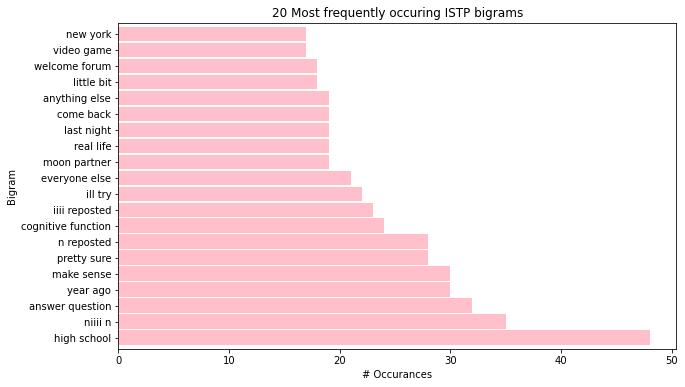

In [56]:
top_20_ISTP_words_bigrams.sort_values(ascending=False).plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring ISTP bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_ISTP_words_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

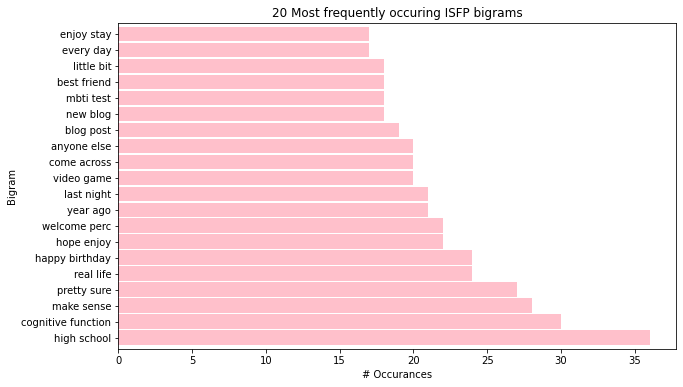

In [57]:
top_20_ISFP_words_bigrams.sort_values(ascending=False).plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring ISFP bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_ISFP_words_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

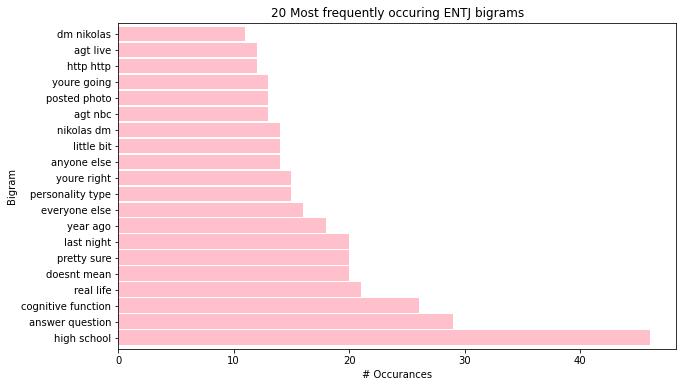

In [58]:
top_20_ENTJ_words_bigrams.sort_values(ascending=False).plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring ENTJ bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_ENTJ_words_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

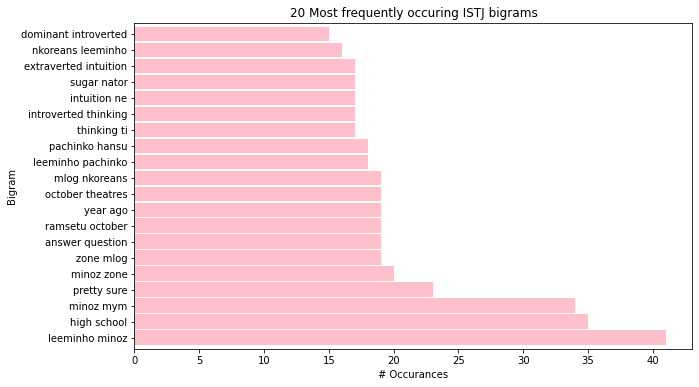

In [59]:
top_20_ISTJ_words_bigrams.sort_values(ascending=False).plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring ISTJ bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_ISTJ_words_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

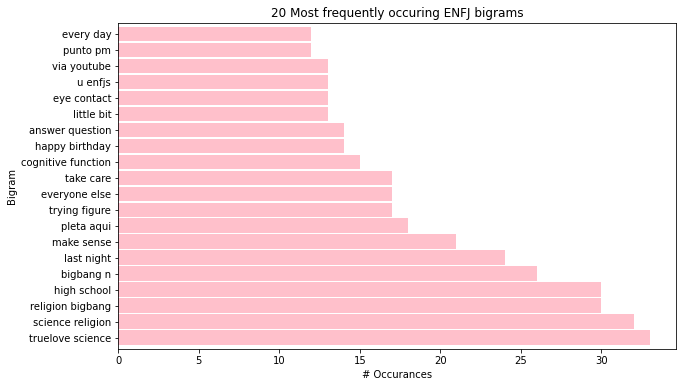

In [60]:
top_20_ENFJ_words_bigrams.sort_values(ascending=False).plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring ENFJ bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_ENFJ_words_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

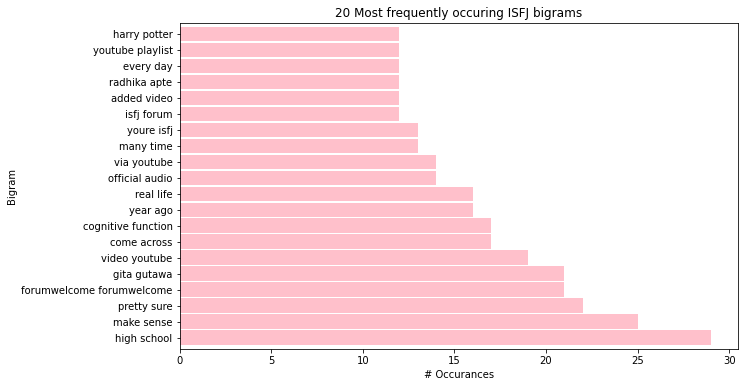

In [61]:
top_20_ISFJ_words_bigrams.sort_values(ascending=False).plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring ISFJ bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_ISFJ_words_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

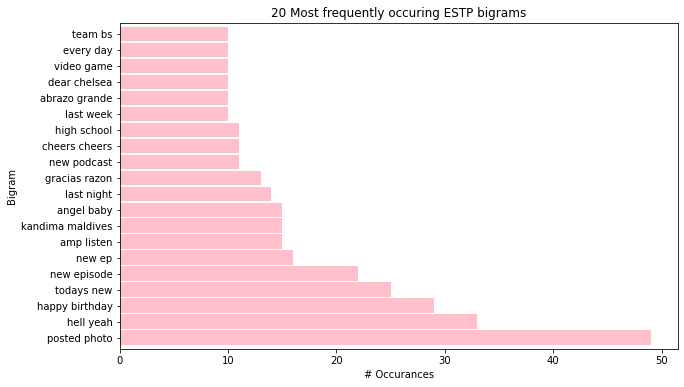

In [62]:
top_20_ESTP_words_bigrams.sort_values(ascending=False).plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring ESTP bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_ESTP_words_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

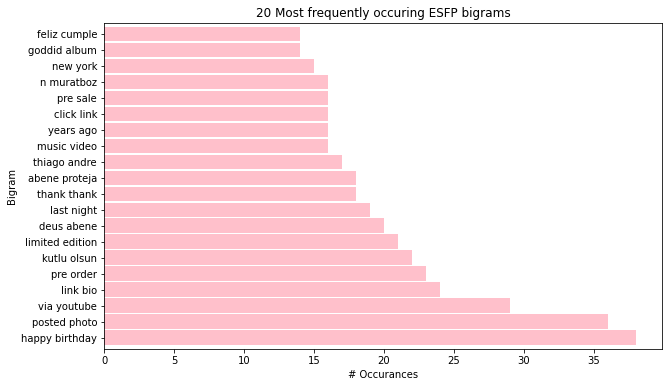

In [63]:
top_20_ESFP_words_bigrams.sort_values(ascending=False).plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring ESFP bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_ESFP_words_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

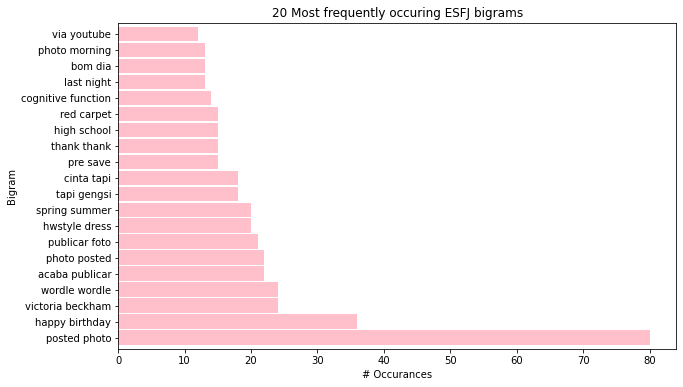

In [64]:
top_20_ESFJ_words_bigrams.sort_values(ascending=False).plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring ESFJ bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_ESFJ_words_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

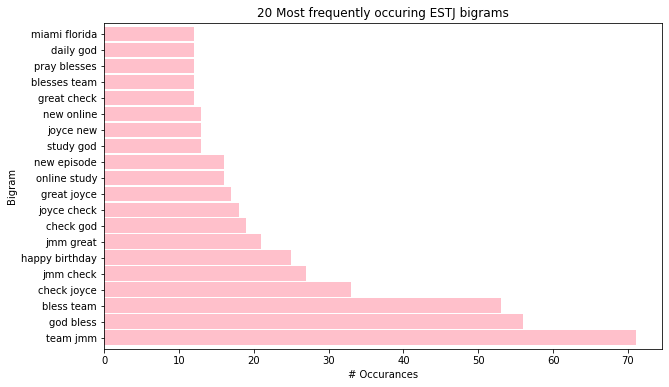

In [65]:
top_20_ESTJ_words_bigrams.sort_values(ascending=False).plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring ESTJ bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_ESTJ_words_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

## Most common bigrams by personality type
- ESTJ 'team jmm'
- ESFJ 'posted photo'
- ESFP 'de la'
- ESTP 'posted photo'
- ISFJ 'high school'
- 

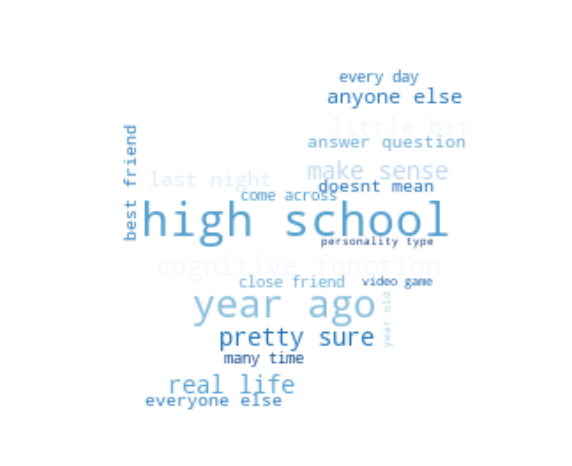

In [66]:
# Plot the wordcloud with the mask applied
data = {k[0] + ' ' + k[1]: v for k, v in top_20_all_words_bigrams.to_dict().items()}
wc = WordCloud(background_color='white', mask= twitter_mask, colormap = 'Blues').generate_from_frequencies(data)
plt.figure(figsize=[10,10])
plt.tight_layout()
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

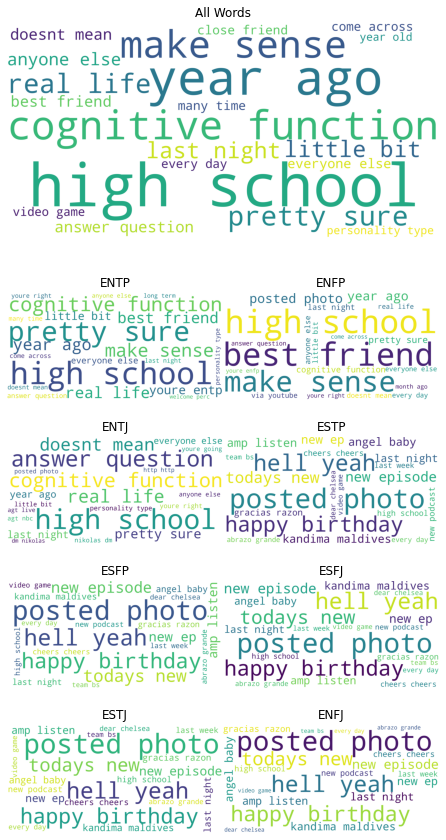

In [67]:
data = {k[0] + ' ' + k[1]: v for k, v in top_20_all_words_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=4000, height=2000).generate_from_frequencies(data)

data2 = {k[0] + ' ' + k[1]: v for k, v in top_20_ENTP_words_bigrams.to_dict().items()}
img2 = WordCloud(background_color='white', width=2000, height=1000).generate_from_frequencies(data2)

data3 = {k[0] + ' ' + k[1]: v for k, v in top_20_ENFP_words_bigrams.to_dict().items()}
img3 = WordCloud(background_color='white', width=2000, height=1000).generate_from_frequencies(data3)

data4 = {k[0] + ' ' + k[1]: v for k, v in top_20_ENTJ_words_bigrams.to_dict().items()}
img4 = WordCloud(background_color='white', width=2000, height=1000).generate_from_frequencies(data4)

data5 = {k[0] + ' ' + k[1]: v for k, v in top_20_ESTP_words_bigrams.to_dict().items()}
img5 = WordCloud(background_color='white', width=2000, height=1000).generate_from_frequencies(data5)

data6 = {k[0] + ' ' + k[1]: v for k, v in top_20_ESFP_words_bigrams.to_dict().items()}
img6 = WordCloud(background_color='white', width=2000, height=1000).generate_from_frequencies(data5)

data7 = {k[0] + ' ' + k[1]: v for k, v in top_20_ESFJ_words_bigrams.to_dict().items()}
img7 = WordCloud(background_color='white', width=2000, height=1000).generate_from_frequencies(data5)

data8 = {k[0] + ' ' + k[1]: v for k, v in top_20_ESTJ_words_bigrams.to_dict().items()}
img8 = WordCloud(background_color='white', width=2000, height=1000).generate_from_frequencies(data5)

data9 = {k[0] + ' ' + k[1]: v for k, v in top_20_ENFJ_words_bigrams.to_dict().items()}
img9 = WordCloud(background_color='white', width=2000, height=1000).generate_from_frequencies(data5)
# Set the axis
axs = [plt.axes([.5, 0, .5, .5]), plt.axes([0, 0, .5, .5]), plt.axes([.5, .5, .5, .5])
       , plt.axes([0, .5, .5, .5]), plt.axes([.5, 1, .5, .5]), plt.axes([0, 1, .5, .5])
       , plt.axes([.5, 1.5, .5, .5]), plt.axes([0, 1.5, .5, .5]), plt.axes([0, 2, 1, 1])]
# Plot the results
axs[8].imshow(img)
axs[7].imshow(img2)
axs[6].imshow(img3)
axs[5].imshow(img4)
axs[4].imshow(img5)
axs[3].imshow(img6)
axs[2].imshow(img7)
axs[1].imshow(img8)
axs[0].imshow(img9)
# Make titles
axs[8].set_title('All Words')
axs[7].set_title('ENTP')
axs[6].set_title('ENFP')
axs[5].set_title('ENTJ')
axs[4].set_title('ESTP')
axs[3].set_title('ESFP')
axs[2].set_title('ESFJ')
axs[1].set_title('ESTJ')
axs[0].set_title('ENFJ')
for ax in axs: ax.axis('off')
plt.show()

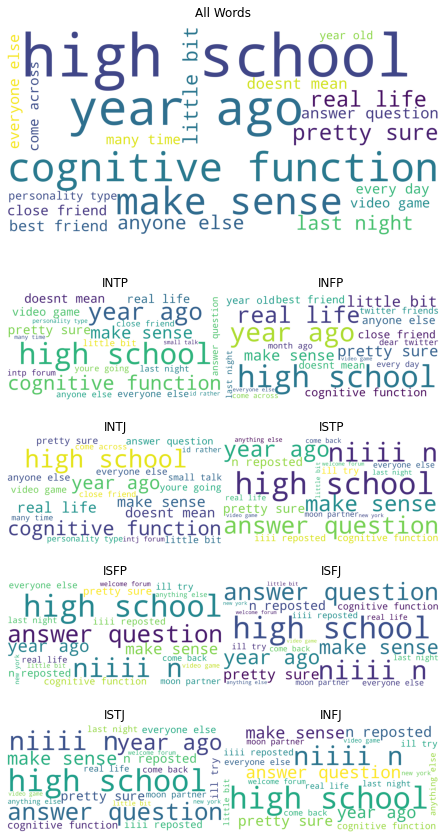

In [68]:
data = {k[0] + ' ' + k[1]: v for k, v in top_20_all_words_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=4000, height=2000).generate_from_frequencies(data)

data2 = {k[0] + ' ' + k[1]: v for k, v in top_20_INTP_words_bigrams.to_dict().items()}
img2 = WordCloud(background_color='white', width=2000, height=1000).generate_from_frequencies(data2)

data3 = {k[0] + ' ' + k[1]: v for k, v in top_20_INFP_words_bigrams.to_dict().items()}
img3 = WordCloud(background_color='white', width=2000, height=1000).generate_from_frequencies(data3)

data4 = {k[0] + ' ' + k[1]: v for k, v in top_20_INTJ_words_bigrams.to_dict().items()}
img4 = WordCloud(background_color='white', width=2000, height=1000).generate_from_frequencies(data4)

data5 = {k[0] + ' ' + k[1]: v for k, v in top_20_ISTP_words_bigrams.to_dict().items()}
img5 = WordCloud(background_color='white', width=2000, height=1000).generate_from_frequencies(data5)

data6 = {k[0] + ' ' + k[1]: v for k, v in top_20_ISFP_words_bigrams.to_dict().items()}
img6 = WordCloud(background_color='white', width=2000, height=1000).generate_from_frequencies(data5)

data7 = {k[0] + ' ' + k[1]: v for k, v in top_20_ISFJ_words_bigrams.to_dict().items()}
img7 = WordCloud(background_color='white', width=2000, height=1000).generate_from_frequencies(data5)

data8 = {k[0] + ' ' + k[1]: v for k, v in top_20_ISTJ_words_bigrams.to_dict().items()}
img8 = WordCloud(background_color='white', width=2000, height=1000).generate_from_frequencies(data5)

data9 = {k[0] + ' ' + k[1]: v for k, v in top_20_INFJ_words_bigrams.to_dict().items()}
img9 = WordCloud(background_color='white', width=2000, height=1000).generate_from_frequencies(data5)
# Set the axis
axs = [plt.axes([.5, 0, .5, .5]), plt.axes([0, 0, .5, .5]), plt.axes([.5, .5, .5, .5])
       , plt.axes([0, .5, .5, .5]), plt.axes([.5, 1, .5, .5]), plt.axes([0, 1, .5, .5])
       , plt.axes([.5, 1.5, .5, .5]), plt.axes([0, 1.5, .5, .5]), plt.axes([0, 2, 1, 1])]
# Plot the results
axs[8].imshow(img)
axs[7].imshow(img2)
axs[6].imshow(img3)
axs[5].imshow(img4)
axs[4].imshow(img5)
axs[3].imshow(img6)
axs[2].imshow(img7)
axs[1].imshow(img8)
axs[0].imshow(img9)
# Make titles
axs[8].set_title('All Words')
axs[7].set_title('INTP')
axs[6].set_title('INFP')
axs[5].set_title('INTJ')
axs[4].set_title('ISTP')
axs[3].set_title('ISFP')
axs[2].set_title('ISFJ')
axs[1].set_title('ISTJ')
axs[0].set_title('INFJ')
for ax in axs: ax.axis('off')
plt.show()

## Trigrams

In [69]:
top_20_all_words_trigrams = (pd.Series(nltk.ngrams(all_words, 3))
                      .value_counts()
                      .head(20))
top_20_INFP_words_trigrams = (pd.Series(nltk.ngrams(INFP_words, 3))
                      .value_counts()
                      .head(20))
top_20_INFJ_words_trigrams = (pd.Series(nltk.ngrams(INFJ_words, 3))
                      .value_counts()
                      .head(20))
top_20_INTP_words_trigrams = (pd.Series(nltk.ngrams(INTP_words, 3))
                      .value_counts()
                      .head(20))
top_20_INTJ_words_trigrams = (pd.Series(nltk.ngrams(INTJ_words, 3))
                      .value_counts()
                      .head(20))
top_20_ENTP_words_trigrams = (pd.Series(nltk.ngrams(ENTP_words, 3))
                      .value_counts()
                      .head(20))
top_20_ENFP_words_trigrams = (pd.Series(nltk.ngrams(ENFP_words, 3))
                      .value_counts()
                      .head(20))
top_20_ISTP_words_trigrams = (pd.Series(nltk.ngrams(ISTP_words, 3))
                      .value_counts()
                      .head(20))
top_20_ISFP_words_trigrams = (pd.Series(nltk.ngrams(ISFP_words, 3))
                      .value_counts()
                      .head(20))
top_20_ENTJ_words_trigrams = (pd.Series(nltk.ngrams(ENTJ_words, 3))
                      .value_counts()
                      .head(20))
top_20_ISTJ_words_trigrams = (pd.Series(nltk.ngrams(ISTJ_words, 3))
                      .value_counts()
                      .head(20))
top_20_ENFJ_words_trigrams = (pd.Series(nltk.ngrams(ENFJ_words, 3))
                      .value_counts()
                      .head(20))
top_20_ISFJ_words_trigrams = (pd.Series(nltk.ngrams(ISFJ_words, 3))
                      .value_counts()
                      .head(20))
top_20_ESTP_words_trigrams = (pd.Series(nltk.ngrams(ESTP_words, 3))
                      .value_counts()
                      .head(20))
top_20_ESFP_words_trigrams = (pd.Series(nltk.ngrams(ESFP_words, 3))
                      .value_counts()
                      .head(20))
top_20_ESFJ_words_trigrams = (pd.Series(nltk.ngrams(ESFJ_words, 3))
                      .value_counts()
                      .head(20))
top_20_ESTJ_words_trigrams = (pd.Series(nltk.ngrams(ESTJ_words, 3))
                      .value_counts()
                      .head(20))

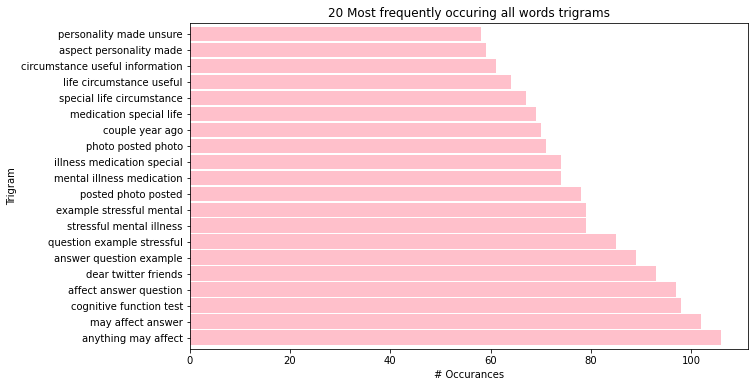

In [70]:
top_20_all_words_trigrams.sort_values(ascending=False).plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring all words trigrams')
plt.ylabel('Trigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_all_words_trigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1] + ' ' + t[2])
_ = plt.yticks(ticks, labels)

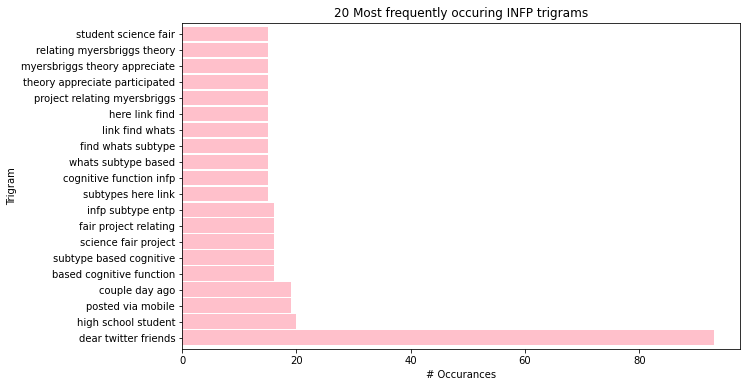

In [71]:
top_20_INFP_words_trigrams.sort_values(ascending=False).plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring INFP trigrams')
plt.ylabel('Trigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_INFP_words_trigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1] + ' ' + t[2])
_ = plt.yticks(ticks, labels)

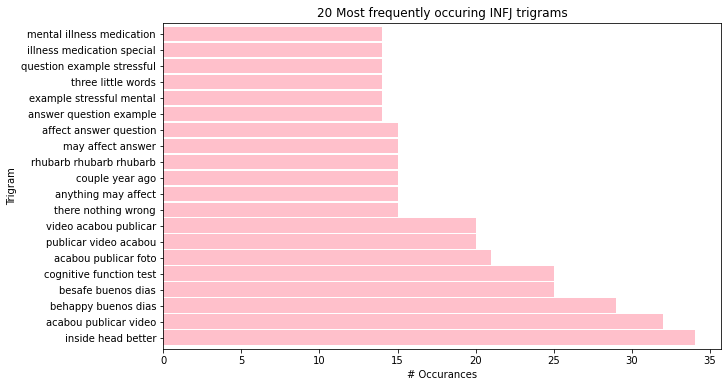

In [72]:
top_20_INFJ_words_trigrams.sort_values(ascending=False).plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring INFJ trigrams')
plt.ylabel('Trigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_INFJ_words_trigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1] + ' ' + t[2])
_ = plt.yticks(ticks, labels)

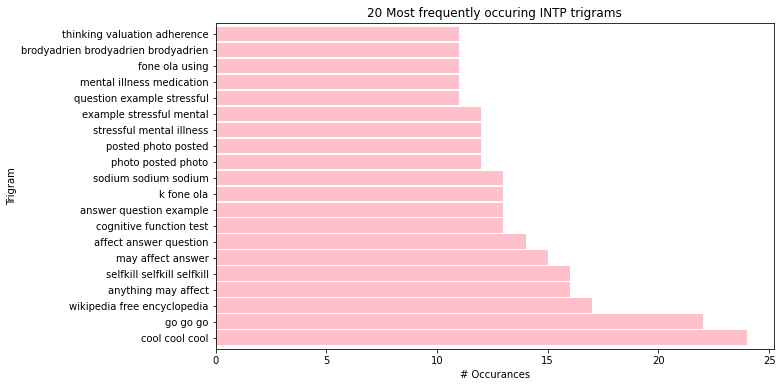

In [73]:
top_20_INTP_words_trigrams.sort_values(ascending=False).plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring INTP trigrams')
plt.ylabel('Trigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_INTP_words_trigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1] + ' ' + t[2])
_ = plt.yticks(ticks, labels)

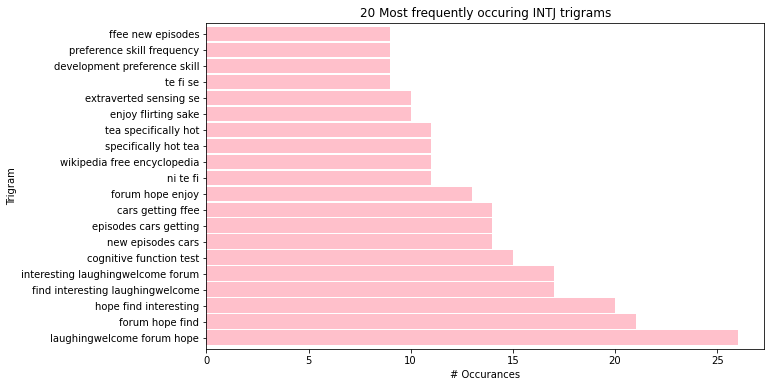

In [74]:
top_20_INTJ_words_trigrams.sort_values(ascending=False).plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring INTJ trigrams')
plt.ylabel('Trigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_INTJ_words_trigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1] + ' ' + t[2])
_ = plt.yticks(ticks, labels)

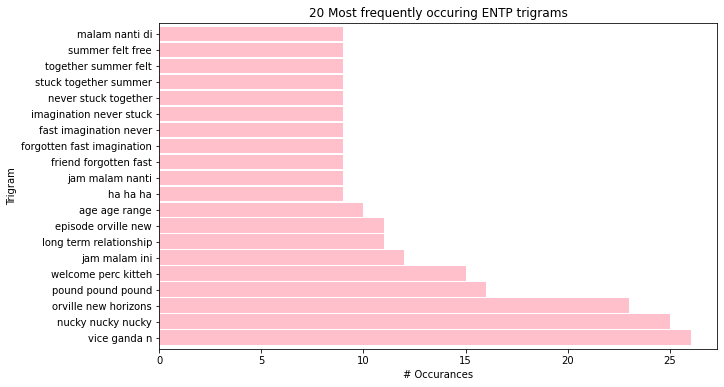

In [75]:
top_20_ENTP_words_trigrams.sort_values(ascending=False).plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring ENTP trigrams')
plt.ylabel('Trigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_ENTP_words_trigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1] + ' ' + t[2])
_ = plt.yticks(ticks, labels)

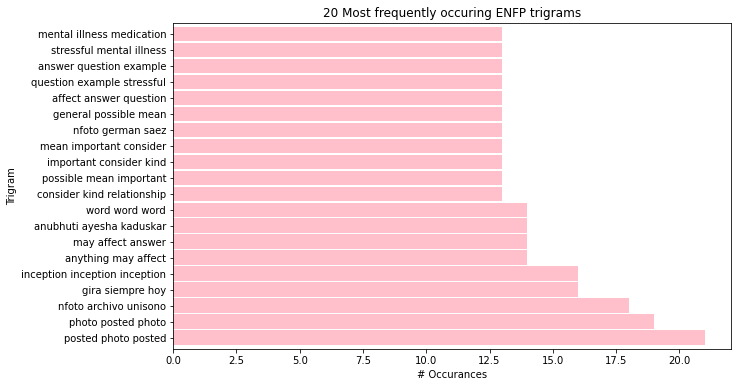

In [76]:
top_20_ENFP_words_trigrams.sort_values(ascending=False).plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring ENFP trigrams')
plt.ylabel('Trigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_ENFP_words_trigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1] + ' ' + t[2])
_ = plt.yticks(ticks, labels)

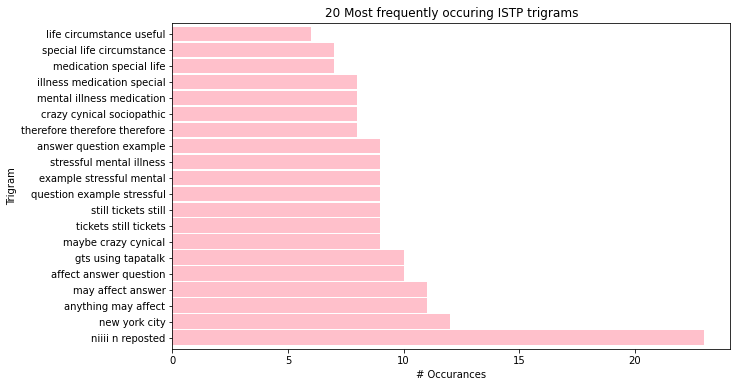

In [77]:
top_20_ISTP_words_trigrams.sort_values(ascending=False).plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring ISTP trigrams')
plt.ylabel('Trigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_ISTP_words_trigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1] + ' ' + t[2])
_ = plt.yticks(ticks, labels)

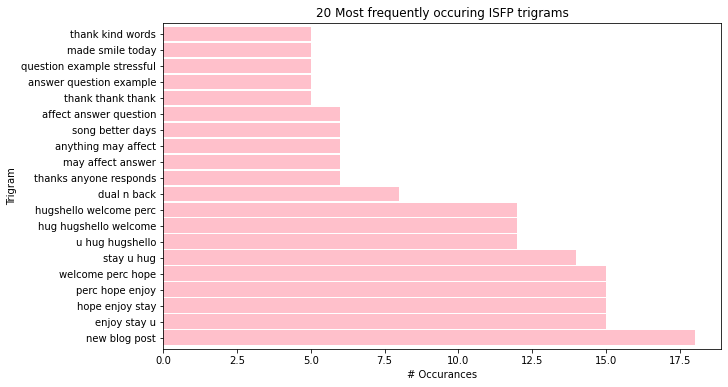

In [78]:
top_20_ISFP_words_trigrams.sort_values(ascending=False).plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring ISFP trigrams')
plt.ylabel('Trigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_ISFP_words_trigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1] + ' ' + t[2])
_ = plt.yticks(ticks, labels)

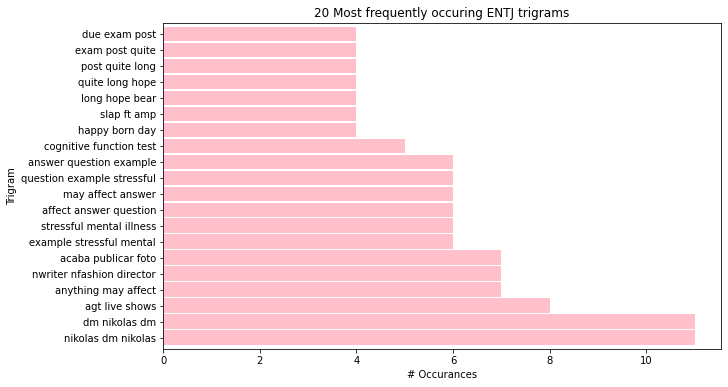

In [79]:
top_20_ENTJ_words_trigrams.sort_values(ascending=False).plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring ENTJ trigrams')
plt.ylabel('Trigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_ENTJ_words_trigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1] + ' ' + t[2])
_ = plt.yticks(ticks, labels)

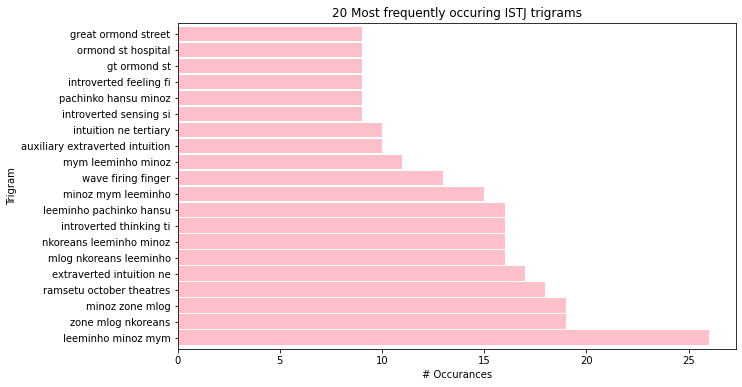

In [80]:
top_20_ISTJ_words_trigrams.sort_values(ascending=False).plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring ISTJ trigrams')
plt.ylabel('Trigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_ISTJ_words_trigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1] + ' ' + t[2])
_ = plt.yticks(ticks, labels)

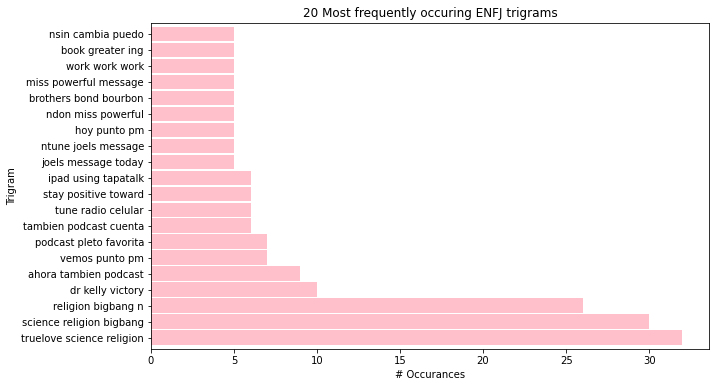

In [81]:
top_20_ENFJ_words_trigrams.sort_values(ascending=False).plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring ENFJ trigrams')
plt.ylabel('Trigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_ENFJ_words_trigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1] + ' ' + t[2])
_ = plt.yticks(ticks, labels)

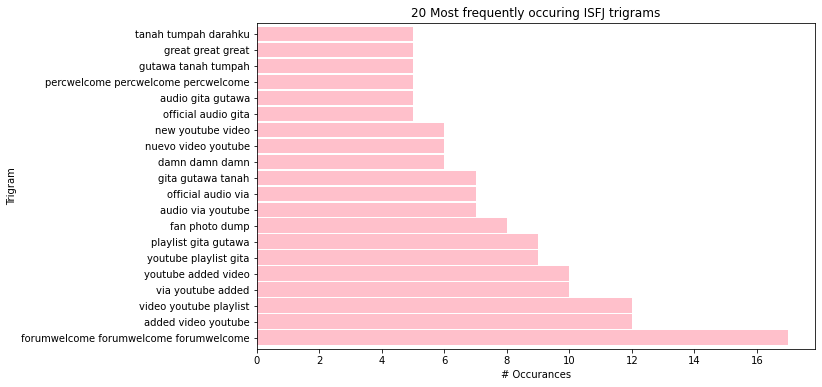

In [82]:
top_20_ISFJ_words_trigrams.sort_values(ascending=False).plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring ISFJ trigrams')
plt.ylabel('Trigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_ISFJ_words_trigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1] + ' ' + t[2])
_ = plt.yticks(ticks, labels)

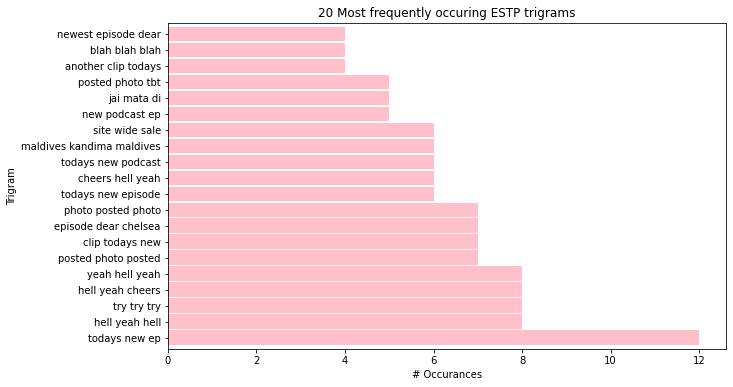

In [83]:
top_20_ESTP_words_trigrams.sort_values(ascending=False).plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring ESTP trigrams')
plt.ylabel('Trigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_ESTP_words_trigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1] + ' ' + t[2])
_ = plt.yticks(ticks, labels)

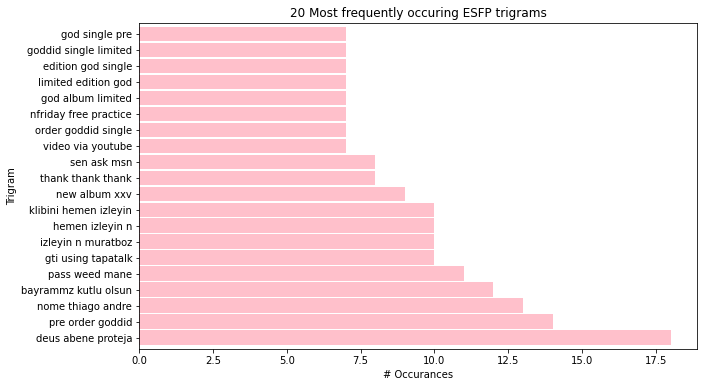

In [84]:
top_20_ESFP_words_trigrams.sort_values(ascending=False).plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring ESFP trigrams')
plt.ylabel('Trigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_ESFP_words_trigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1] + ' ' + t[2])
_ = plt.yticks(ticks, labels)

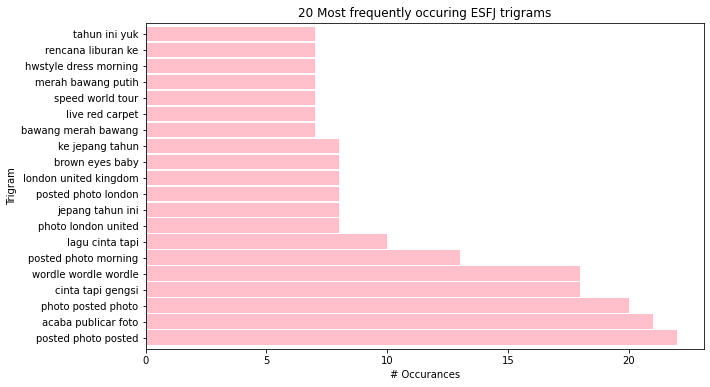

In [85]:
top_20_ESFJ_words_trigrams.sort_values(ascending=False).plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring ESFJ trigrams')
plt.ylabel('Trigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_ESFJ_words_trigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1] + ' ' + t[2])
_ = plt.yticks(ticks, labels)

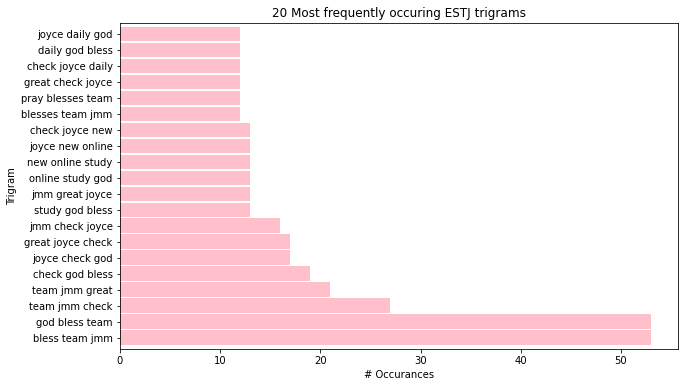

In [86]:
top_20_ESTJ_words_trigrams.sort_values(ascending=False).plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring ESTJ trigrams')
plt.ylabel('Trigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_ESTJ_words_trigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1] + ' ' + t[2])
_ = plt.yticks(ticks, labels)

## Model using 16 personalities

In [87]:
df.type.value_counts()

INFP    1847
INFJ    1497
INTP    1315
INTJ    1102
ENTP     736
ENFP     735
ISTP     367
ISFP     320
ENTJ     253
ENFJ     227
ISTJ     217
ISFJ     198
ESFP     151
ESTP     139
ESFJ     108
ESTJ      62
Name: type, dtype: int64

In [88]:
df.shape

(9274, 7)

In [89]:
print('Baseline Accuracy:',round((1832/8675) * 100, 2),'%')

Baseline Accuracy: 21.12 %


In [90]:
# Make the object
tfidf = TfidfVectorizer()
# Fit/Transform
X = tfidf.fit_transform(df.lemmatized)
# What we are predicting
y = df.type
# Split X and y into train, validate, and test 
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, stratify=y, test_size=.2, random_state=123)
X_train, X_validate, y_train, y_validate = train_test_split(X_train_val, y_train_val, stratify=y_train_val, test_size=.25, random_state=123)
# Make train and validate a dataframe
train = pd.DataFrame(dict(actual=y_train))
validate = pd.DataFrame(dict(actual=y_validate))
# Make the object and fit it
lm = LogisticRegression().fit(X_train, y_train)
# Make columns for the predictions
train['predicted_lm'] = lm.predict(X_train)
validate['predicted_lm'] = lm.predict(X_validate)
# Make the object and fit it
MNBclf = MultinomialNB()
MNBclf.fit(X_train, y_train)
# Make columns for the predictions
train['predicted_MNBclf'] = MNBclf.predict(X_train)
validate['predicted_MNBclf'] = MNBclf.predict(X_validate)

# Make the object and fit/transform it
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df.lemmatized)
# Split X and y into train, validate, and test.
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, stratify=y, test_size=.2, random_state=123)
X_train, X_validate, y_train, y_validate = train_test_split(X_train_val, y_train_val, stratify=y_train_val, test_size=.25, random_state=123)
# Make the object and fit it
lm = LogisticRegression().fit(X_train, y_train)
# Make columns for the predictions
train['bow_predicted_lm'] = lm.predict(X_train)
validate['bow_predicted_lm'] = lm.predict(X_validate)
# Make the object and fit it
MNBclf = MultinomialNB()
MNBclf.fit(X_train, y_train)
# Make columns for the predictions
train['bow_predicted_MNBclf'] = MNBclf.predict(X_train)
validate['bow_predicted_MNBclf'] = MNBclf.predict(X_validate)

# Print out the results
print('Bag of Words Logistic Regression Train Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.bow_predicted_lm)))
print('-------------')
print('Bag of Words Logistic Regression Validate Accuracy: {:.2%}'.format(accuracy_score(validate.actual, validate.bow_predicted_lm)))
print('-------------')
print('Bag of Words MultinomialNB Train Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.bow_predicted_MNBclf)))
print('-------------')
print('Bag of Words MultinomialNB Validate Accuracy: {:.2%}'.format(accuracy_score(validate.actual, validate.bow_predicted_MNBclf)))
print('-------------')
print('TF-IDF MultinomialNB Train Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted_MNBclf)))
print('-------------')
print('TF-IDF MultinomialNB Validate Accuracy: {:.2%}'.format(accuracy_score(validate.actual, validate.predicted_MNBclf)))
print('-------------')
print('TF-IDF Logistic Regression Train Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted_lm)))
print('-------------')
print('TF-IDF Logistic Regression Validate Accuracy: {:.2%}'.format(accuracy_score(validate.actual, validate.predicted_lm)))
print('-------------')

Bag of Words Logistic Regression Train Accuracy: 100.00%
-------------
Bag of Words Logistic Regression Validate Accuracy: 58.11%
-------------
Bag of Words MultinomialNB Train Accuracy: 55.66%
-------------
Bag of Words MultinomialNB Validate Accuracy: 23.18%
-------------
TF-IDF MultinomialNB Train Accuracy: 20.38%
-------------
TF-IDF MultinomialNB Validate Accuracy: 19.89%
-------------
TF-IDF Logistic Regression Train Accuracy: 81.00%
-------------
TF-IDF Logistic Regression Validate Accuracy: 56.93%
-------------


In [91]:
# Make the object and fit/transform it
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df.lemmatized)
# What we are predicting
y = df.type

# Split X and y into train, validate, and test.
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, stratify=y, test_size=.2, random_state=123)
X_train, X_validate, y_train, y_validate = train_test_split(X_train_val, y_train_val, stratify=y_train_val, test_size=.25, random_state=123)

# Loop Random forest
metrics = []
max_depth = 20

for i in range(2, max_depth):
    # Make the model
    depth = max_depth - i
    n_samples = i
    forest = RandomForestClassifier(max_depth=depth, min_samples_leaf=n_samples, random_state=123)

    # Fit the model (on train and only train)
    forest = forest.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    in_sample_accuracy = forest.score(X_train, y_train)
    
    out_of_sample_accuracy = forest.score(X_validate, y_validate)

    output = {
        "min_samples_per_leaf": n_samples,
        "max_depth": depth,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }
    
    metrics.append(output)
    
bow_random_forest = pd.DataFrame(metrics)
bow_random_forest["difference"] = bow_random_forest.train_accuracy - bow_random_forest.validate_accuracy
bow_random_forest

min_samples_per_leaf  max_depth  train_accuracy  validate_accuracy  \
0                      2         18        0.483645           0.246900   
1                      3         17        0.423436           0.237197   
2                      4         16        0.379583           0.229111   
3                      5         15        0.346693           0.230728   
4                      6         14        0.305536           0.216712   
5                      7         13        0.287383           0.212399   
6                      8         12        0.262042           0.210782   
7                      9         11        0.232746           0.204852   
8                     10         10        0.220525           0.203235   
9                     11          9        0.215672           0.201078   
10                    12          8        0.207225           0.202156   
11                    13          7        0.203451           0.200000   
12                    14          6        0.203091           0.200000   
13                    15          5        0.199497           0.198922   
14                    16          4        0.199676           0.198922   
15                    17          3        0.199137           0.198922   
16                    18          2        0.199137           0.198922   
17                    19          1        0.199137           0.198922   

    difference  
0     0.236745  
1     0.186240  
2     0.150473  
3     0.115965  
4     0.088824  
5     0.074984  
6     0.051260  
7     0.027894  
8     0.017290  
9     0.014594  
10    0.005069  
11    0.003451  
12    0.003091  
13    0.000575  
14    0.000755  
15    0.000215  
16    0.000215  
17    0.000215

In [92]:
# Make the object
tfidf = TfidfVectorizer()
# Fit/Transform
X = tfidf.fit_transform(df.lemmatized)
# What we are predicting
y = df.type

# Split X and y into train, validate, and test 
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, stratify=y, test_size=.2, random_state=123)
X_train, X_validate, y_train, y_validate = train_test_split(X_train_val, y_train_val, stratify=y_train_val, test_size=.25, random_state=123)

# Loop Random forest
metrics = []
max_depth = 20

for i in range(2, max_depth):
    # Make the model
    depth = max_depth - i
    n_samples = i
    forest = RandomForestClassifier(max_depth=depth, min_samples_leaf=n_samples, random_state=123)

    # Fit the model (on train and only train)
    forest = forest.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    in_sample_accuracy = forest.score(X_train, y_train)
    
    out_of_sample_accuracy = forest.score(X_validate, y_validate)

    output = {
        "min_samples_per_leaf": n_samples,
        "max_depth": depth,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }
    
    metrics.append(output)
    
tfidf_random_forest = pd.DataFrame(metrics)
tfidf_random_forest["difference"] = tfidf_random_forest.train_accuracy - tfidf_random_forest.validate_accuracy
tfidf_random_forest


min_samples_per_leaf  max_depth  train_accuracy  validate_accuracy  \
0                      2         18        0.553019           0.256604   
1                      3         17        0.478792           0.259838   
2                      4         16        0.435838           0.246900   
3                      5         15        0.394141           0.244744   
4                      6         14        0.371495           0.249596   
5                      7         13        0.335730           0.230189   
6                      8         12        0.313803           0.230189   
7                      9         11        0.283968           0.225876   
8                     10         10        0.260424           0.215633   
9                     11          9        0.239576           0.210243   
10                    12          8        0.229511           0.207008   
11                    13          7        0.215672           0.202156   
12                    14          6        0.205248           0.200000   
13                    15          5        0.200575           0.199461   
14                    16          4        0.199317           0.198922   
15                    17          3        0.199137           0.198922   
16                    18          2        0.199137           0.198922   
17                    19          1        0.199137           0.198922   

    difference  
0     0.296416  
1     0.218954  
2     0.188937  
3     0.149397  
4     0.121900  
5     0.105541  
6     0.083614  
7     0.058092  
8     0.044791  
9     0.029333  
10    0.022503  
11    0.013516  
12    0.005248  
13    0.001114  
14    0.000395  
15    0.000215  
16    0.000215  
17    0.000215

## Model using personality domain

In [93]:
df.personality_domain.value_counts()

Diplomat    4306
Analyst     3406
Explorer     977
Sentinel     585
Name: personality_domain, dtype: int64

In [94]:
print('Baseline Accuracy:',round((4167/8675) * 100, 2),'%')

Baseline Accuracy: 48.03 %


In [95]:
# Make the object
tfidf = TfidfVectorizer()
# Fit/Transform
X = tfidf.fit_transform(df.lemmatized)
# What we are predicting
y = df.personality_domain
# Split X and y into train, validate, and test 
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, stratify=y, test_size=.2, random_state=123)
X_train, X_validate, y_train, y_validate = train_test_split(X_train_val, y_train_val, stratify=y_train_val, test_size=.25, random_state=123)
# Make train and validate a dataframe
train = pd.DataFrame(dict(actual=y_train))
validate = pd.DataFrame(dict(actual=y_validate))
# Make the object and fit it
lm = LogisticRegression().fit(X_train, y_train)
# Make columns for the predictions
train['predicted_lm'] = lm.predict(X_train)
validate['predicted_lm'] = lm.predict(X_validate)
# Make the object and fit it
MNBclf = MultinomialNB()
MNBclf.fit(X_train, y_train)
# Make columns for the predictions
train['predicted_MNBclf'] = MNBclf.predict(X_train)
validate['predicted_MNBclf'] = MNBclf.predict(X_validate)

# Make the object and fit/transform it
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df.lemmatized)
# Split X and y into train, validate, and test.
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, stratify=y, test_size=.2, random_state=123)
X_train, X_validate, y_train, y_validate = train_test_split(X_train_val, y_train_val, stratify=y_train_val, test_size=.25, random_state=123)
# Make the object and fit it
lm = LogisticRegression().fit(X_train, y_train)
# Make columns for the predictions
train['bow_predicted_lm'] = lm.predict(X_train)
validate['bow_predicted_lm'] = lm.predict(X_validate)
# Make the object and fit it
MNBclf = MultinomialNB()
MNBclf.fit(X_train, y_train)
# Make columns for the predictions
train['bow_predicted_MNBclf'] = MNBclf.predict(X_train)
validate['bow_predicted_MNBclf'] = MNBclf.predict(X_validate)

# Print out the results
print('Bag of Words Logistic Regression Train Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.bow_predicted_lm)))
print('-------------')
print('Bag of Words Logistic Regression Validate Accuracy: {:.2%}'.format(accuracy_score(validate.actual, validate.bow_predicted_lm)))
print('-------------')
print('Bag of Words MultinomialNB Train Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.bow_predicted_MNBclf)))
print('-------------')
print('Bag of Words MultinomialNB Validate Accuracy: {:.2%}'.format(accuracy_score(validate.actual, validate.bow_predicted_MNBclf)))
print('-------------')
print('TF-IDF MultinomialNB Train Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted_MNBclf)))
print('-------------')
print('TF-IDF MultinomialNB Validate Accuracy: {:.2%}'.format(accuracy_score(validate.actual, validate.predicted_MNBclf)))
print('-------------')
print('TF-IDF Logistic Regression Train Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted_lm)))
print('-------------')
print('TF-IDF Logistic Regression Validate Accuracy: {:.2%}'.format(accuracy_score(validate.actual, validate.predicted_lm)))
print('-------------')

Bag of Words Logistic Regression Train Accuracy: 100.00%
-------------
Bag of Words Logistic Regression Validate Accuracy: 73.85%
-------------
Bag of Words MultinomialNB Train Accuracy: 84.31%
-------------
Bag of Words MultinomialNB Validate Accuracy: 63.13%
-------------
TF-IDF MultinomialNB Train Accuracy: 47.41%
-------------
TF-IDF MultinomialNB Validate Accuracy: 46.68%
-------------
TF-IDF Logistic Regression Train Accuracy: 89.94%
-------------
TF-IDF Logistic Regression Validate Accuracy: 75.20%
-------------


## Not good 👇

In [96]:
# # 60/20/20 Train, Validate, Test split
# train_val, test = train_test_split(df, stratify=df.type, test_size=.2, random_state=123)
# train, validate = train_test_split(train_val, stratify=train_val.type, test_size=.25, random_state=123)

In [97]:
# from sklearn.pipeline import Pipeline
# from sklearn.feature_extraction.text import TfidfTransformer

# text_clf = Pipeline([('vect', CountVectorizer()),
#                      ('tfidf', TfidfTransformer()),
#                      ('clf', MultinomialNB()),
# ])
# text_clf = text_clf.fit(train.lemmatized, train.type)

In [98]:
# from sklearn.model_selection import GridSearchCV
# parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
#               'tfidf__use_idf': (True, False),
#               'clf__alpha': (1e-2, 1e-3),
# }

In [99]:
# gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1)
# gs_clf = gs_clf.fit(train.lemmatized, train.type)

In [100]:
# gs_clf.best_params_

In [101]:
# gs_clf.best_score_

___


## Working on clustering

In [102]:
def run_kmeans(train, max_centroids=15):
    '''
    This function takes in the scaled train data set (continuous features only)
    and the max number of centroids desired.
    
    Outputs the seaborn plot of centroids vs inertia to visualize the 'elbow' method.
    '''
    
    n = 1
    points = {}
    while n <= max_centroids:
        km = KMeans(n_clusters = n)
        km.fit(train)
        points[f'km_{n}'] = {'centroids':n, 'inertia': km.inertia_}
        n+=1
    
    points = pd.DataFrame(points).T
    
    sns.relplot(data=points, x='centroids', y='inertia').set(title='Elbow Method Plot')
    # x = range(0,40,1)
    # y = range(0,40,1)
    # plt.plot(x,y)
    # plt.xlim(0)
    # plt.ylim(0)
    plt.grid()
    plt.show()

In [103]:
# 60/20/20 Train, Validate, Test split
train_val, test = train_test_split(df, stratify=df.type, test_size=.2, random_state=123)
train, validate = train_test_split(train_val, stratify=train_val.type, test_size=.25, random_state=123)

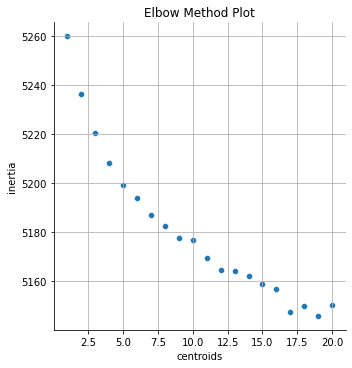

In [104]:
# Make the object
tfidf = TfidfVectorizer()
# Fit/Transform
X = tfidf.fit_transform(train.lemmatized)
run_kmeans(X, 20)



In [105]:
# 60/20/20 Train, Validate, Test split
train_val, test = train_test_split(df, stratify=df.type, test_size=.2, random_state=123)
train, validate = train_test_split(train_val, stratify=train_val.type, test_size=.25, random_state=123)

In [106]:
# Make the object
tfidf = TfidfVectorizer()
# Fit/Transform
X = tfidf.fit_transform(train.lemmatized)

cluster = KMeans(init = 'k-means++', n_clusters=8, n_init=15, random_state=123)
cluster.fit(X)
yhat = cluster.predict(X)
train['cluster'] = cluster.labels_
dummies = pd.get_dummies(train.cluster, prefix='clust')
train = pd.concat([train, dummies], axis=1)

In [107]:
# Transform
X = tfidf.transform(validate.lemmatized)

cluster = KMeans(init = 'k-means++', n_clusters=8, n_init=15, random_state=123)
cluster.fit(X)
yhat = cluster.predict(X)
validate['cluster'] = cluster.labels_
dummies = pd.get_dummies(validate.cluster, prefix='clust')
validate = pd.concat([validate, dummies], axis=1)

In [108]:
# Transform
X = tfidf.transform(test.lemmatized)

cluster = KMeans(init = 'k-means++', n_clusters=8, n_init=15, random_state=123)
cluster.fit(X)
yhat = cluster.predict(X)
test['cluster'] = cluster.labels_
dummies = pd.get_dummies(test.cluster, prefix='clust')
test = pd.concat([test, dummies], axis=1)

In [109]:
# Features
X_train = train[['clust_0', 'clust_1', 'clust_2', 'clust_3', 'clust_4', 'clust_5', 'clust_6', 'clust_7']]
# What we are predicting
y_train = train.type

# Features
X_validate = validate[['clust_0', 'clust_1', 'clust_2', 'clust_3', 'clust_4', 'clust_5', 'clust_6', 'clust_7']]
# What we are predicting
y_validate = validate.type

# Features
X_test = test[['clust_0', 'clust_1', 'clust_2', 'clust_3', 'clust_4', 'clust_5', 'clust_6', 'clust_7']]
# What we are predicting
y_test = test.type


In [110]:
train.head()

type personality_domain I_E N_S T_F J_P  \
3003  INFJ           Diplomat   I   N   F   J   
5724  ENFJ           Diplomat   E   N   F   J   
3729  INTJ            Analyst   I   N   T   J   
2699  ENFJ           Diplomat   E   N   F   J   
2484  ISTP           Explorer   I   S   T   P   

                                             lemmatized  cluster  clust_0  \
3003  viewing profile youre convinced statement exac...        4        0   
5724  another xnfp kissfeet xntj maybe find win than...        1        0   
3729  agree certainly antagonized sufficiently situa...        3        0   
2699  httpswwwyoutubecomwatchvipynxrgqthank song def...        4        0   
2484  heh despise clingy woman guess thats still sin...        3        0   

      clust_1  clust_2  clust_3  clust_4  clust_5  clust_6  clust_7  
3003        0        0        0        1        0        0        0  
5724        1        0        0        0        0        0        0  
3729        0        0        1        0        0        0        0  
2699        0        0        0        1        0        0        0  
2484        0        0        1        0        0        0        0

In [111]:
# from sklearn.feature_selection import SelectKBest, RFE, f_regression, chi2, SequentialFeatureSelector
# kbest = SelectKBest(chi2, k=5)
# kbest.fit(X_train, y_train)
# print(X_train.columns[kbest.get_support()].tolist())


## Model using clusters

In [112]:
# # Make the object
# tfidf = TfidfVectorizer()
# # Fit/Transform
# X = df[['clust_0', 'clust_1', 'clust_2', 'clust_3'
#        , 'clust_4', 'clust_5', 'clust_6', 'clust_7'
#        , 'clust_8', 'clust_9', 'clust_10', 'clust_11'
#        , 'clust_12', 'clust_13', 'clust_14', 'clust_15']]
# # What we are predicting
# y = df.personality_domain
# # Split X and y into train, validate, and test 
# X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, stratify=y, test_size=.2, random_state=123)
# X_train, X_validate, y_train, y_validate = train_test_split(X_train_val, y_train_val, stratify=y_train_val, test_size=.25, random_state=123)
# Make train and validate a dataframe
train = pd.DataFrame(dict(actual=y_train))
validate = pd.DataFrame(dict(actual=y_validate))
# Make the object and fit it
lm = LogisticRegression().fit(X_train, y_train)
# Make columns for the predictions
train['predicted_lm'] = lm.predict(X_train)
validate['predicted_lm'] = lm.predict(X_validate)
# Make the object and fit it
MNBclf = MultinomialNB()
MNBclf.fit(X_train, y_train)
# Make columns for the predictions
train['predicted_MNBclf'] = MNBclf.predict(X_train)
validate['predicted_MNBclf'] = MNBclf.predict(X_validate)


# Print out the results
print('Cluster Logistic Regression Train Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted_lm)))
print('-------------')
print('Cluster Logistic Regression Validate Accuracy: {:.2%}'.format(accuracy_score(validate.actual, validate.predicted_lm)))
print('-------------')
print('Cluster MultinomialNB Train Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted_MNBclf)))
print('-------------')
print('Cluster MultinomialNB Validate Accuracy: {:.2%}'.format(accuracy_score(validate.actual, validate.predicted_MNBclf)))
print('-------------')

Cluster Logistic Regression Train Accuracy: 29.65%
-------------
Cluster Logistic Regression Validate Accuracy: 11.21%
-------------
Cluster MultinomialNB Train Accuracy: 29.65%
-------------
Cluster MultinomialNB Validate Accuracy: 11.21%
-------------


___

## Kaggle data

In [113]:
original = pd.read_csv('mbti_1.csv')
df = prepare_article(original)
df = df[['type', 'lemmatized']]
df['I_E'] = df['type'].astype(str).str[0]
df['N_S'] = df['type'].astype(str).str[1]
df['T_F'] = df['type'].astype(str).str[2]
df['J_P'] = df['type'].astype(str).str[3]
#applying the filter function to 'year_built' column 
df['personality_domain'] = df['type'].apply(filter)
df = df[['type', 'personality_domain', 'I_E', 'N_S', 'T_F', 'J_P', 'lemmatized']]
df.head()

type personality_domain I_E N_S T_F J_P  \
0  INFJ           Diplomat   I   N   F   J   
1  ENTP            Analyst   E   N   T   P   
2  INTP            Analyst   I   N   T   P   
3  INTJ            Analyst   I   N   T   J   
4  ENTJ            Analyst   E   N   T   J   

                                          lemmatized  
0  httpwwwyoutubecomwatchvqsxhcwekrwhttpmediatumb...  
1  finding lack post alarmingsex boring position ...  
2  httpswwwyoutubecomwatchvfhigbolffgwof course t...  
3  dear intp enjoyed conversation day esoteric ga...  
4  youre firedthats another silly misconception a...

In [114]:
# Make the object
tfidf = TfidfVectorizer()
# Fit/Transform
X = tfidf.fit_transform(df.lemmatized)
# What we are predicting
y = df.type
# Split X and y into train, validate, and test 
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, stratify=y, test_size=.2, random_state=123)
X_train, X_validate, y_train, y_validate = train_test_split(X_train_val, y_train_val, stratify=y_train_val, test_size=.25, random_state=123)
# Make train and validate a dataframe
train = pd.DataFrame(dict(actual=y_train))
validate = pd.DataFrame(dict(actual=y_validate))
# Make the object and fit it
lm = LogisticRegression().fit(X_train, y_train)
# Make columns for the predictions
train['predicted_lm'] = lm.predict(X_train)
validate['predicted_lm'] = lm.predict(X_validate)
# Make the object and fit it
MNBclf = MultinomialNB()
MNBclf.fit(X_train, y_train)
# Make columns for the predictions
train['predicted_MNBclf'] = MNBclf.predict(X_train)
validate['predicted_MNBclf'] = MNBclf.predict(X_validate)

# Make the object and fit/transform it
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df.lemmatized)
# Split X and y into train, validate, and test.
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, stratify=y, test_size=.2, random_state=123)
X_train, X_validate, y_train, y_validate = train_test_split(X_train_val, y_train_val, stratify=y_train_val, test_size=.25, random_state=123)
# Make the object and fit it
lm = LogisticRegression().fit(X_train, y_train)
# Make columns for the predictions
train['bow_predicted_lm'] = lm.predict(X_train)
validate['bow_predicted_lm'] = lm.predict(X_validate)
# Make the object and fit it
MNBclf = MultinomialNB()
MNBclf.fit(X_train, y_train)
# Make columns for the predictions
train['bow_predicted_MNBclf'] = MNBclf.predict(X_train)
validate['bow_predicted_MNBclf'] = MNBclf.predict(X_validate)

# Print out the results
print('Bag of Words Logistic Regression Train Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.bow_predicted_lm)))
print('-------------')
print('Bag of Words Logistic Regression Validate Accuracy: {:.2%}'.format(accuracy_score(validate.actual, validate.bow_predicted_lm)))
print('-------------')
print('Bag of Words MultinomialNB Train Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.bow_predicted_MNBclf)))
print('-------------')
print('Bag of Words MultinomialNB Validate Accuracy: {:.2%}'.format(accuracy_score(validate.actual, validate.bow_predicted_MNBclf)))
print('-------------')
print('TF-IDF MultinomialNB Train Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted_MNBclf)))
print('-------------')
print('TF-IDF MultinomialNB Validate Accuracy: {:.2%}'.format(accuracy_score(validate.actual, validate.predicted_MNBclf)))
print('-------------')
print('TF-IDF Logistic Regression Train Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted_lm)))
print('-------------')
print('TF-IDF Logistic Regression Validate Accuracy: {:.2%}'.format(accuracy_score(validate.actual, validate.predicted_lm)))
print('-------------')

Bag of Words Logistic Regression Train Accuracy: 100.00%
-------------
Bag of Words Logistic Regression Validate Accuracy: 60.23%
-------------
Bag of Words MultinomialNB Train Accuracy: 56.08%
-------------
Bag of Words MultinomialNB Validate Accuracy: 25.30%
-------------
TF-IDF MultinomialNB Train Accuracy: 21.38%
-------------
TF-IDF MultinomialNB Validate Accuracy: 21.10%
-------------
TF-IDF Logistic Regression Train Accuracy: 81.40%
-------------
TF-IDF Logistic Regression Validate Accuracy: 57.81%
-------------


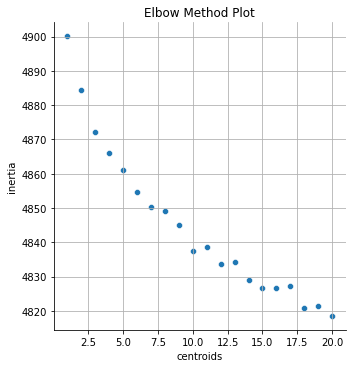

In [115]:
# 60/20/20 Train, Validate, Test split
train_val, test = train_test_split(df, stratify=df.type, test_size=.2, random_state=123)
train, validate = train_test_split(train_val, stratify=train_val.type, test_size=.25, random_state=123)

# Make the object
tfidf = TfidfVectorizer()
# Fit/Transform
X = tfidf.fit_transform(train.lemmatized)
run_kmeans(X, 20)

In [116]:
# Make the object
tfidf = TfidfVectorizer()
# Fit/Transform
X = tfidf.fit_transform(train.lemmatized)

cluster = KMeans(init = 'k-means++', n_clusters=8, n_init=15, random_state=123)
cluster.fit(X)
yhat = cluster.predict(X)
train['cluster'] = cluster.labels_
dummies = pd.get_dummies(train.cluster, prefix='clust')
train = pd.concat([train, dummies], axis=1)

# Transform
X = tfidf.transform(validate.lemmatized)

cluster = KMeans(init = 'k-means++', n_clusters=8, n_init=15, random_state=123)
cluster.fit(X)
yhat = cluster.predict(X)
validate['cluster'] = cluster.labels_
dummies = pd.get_dummies(validate.cluster, prefix='clust')
validate = pd.concat([validate, dummies], axis=1)

# Transform
X = tfidf.transform(test.lemmatized)

cluster = KMeans(init = 'k-means++', n_clusters=8, n_init=15, random_state=123)
cluster.fit(X)
yhat = cluster.predict(X)
test['cluster'] = cluster.labels_
dummies = pd.get_dummies(test.cluster, prefix='clust')
test = pd.concat([test, dummies], axis=1)

# Features
X_train = train[['clust_0', 'clust_1', 'clust_2', 'clust_3', 'clust_4', 'clust_5', 'clust_6', 'clust_7']]
# What we are predicting
y_train = train.type

# Features
X_validate = validate[['clust_0', 'clust_1', 'clust_2', 'clust_3', 'clust_4', 'clust_5', 'clust_6', 'clust_7']]
# What we are predicting
y_validate = validate.type

# Features
X_test = test[['clust_0', 'clust_1', 'clust_2', 'clust_3', 'clust_4', 'clust_5', 'clust_6', 'clust_7']]
# What we are predicting
y_test = test.type

# Make train and validate a dataframe
train = pd.DataFrame(dict(actual=y_train))
validate = pd.DataFrame(dict(actual=y_validate))
# Make the object and fit it
lm = LogisticRegression().fit(X_train, y_train)
# Make columns for the predictions
train['predicted_lm'] = lm.predict(X_train)
validate['predicted_lm'] = lm.predict(X_validate)
# Make the object and fit it
MNBclf = MultinomialNB()
MNBclf.fit(X_train, y_train)
# Make columns for the predictions
train['predicted_MNBclf'] = MNBclf.predict(X_train)
validate['predicted_MNBclf'] = MNBclf.predict(X_validate)


# Print out the results
print('Cluster Logistic Regression Train Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted_lm)))
print('-------------')
print('Cluster Logistic Regression Validate Accuracy: {:.2%}'.format(accuracy_score(validate.actual, validate.predicted_lm)))
print('-------------')
print('Cluster MultinomialNB Train Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted_MNBclf)))
print('-------------')
print('Cluster MultinomialNB Validate Accuracy: {:.2%}'.format(accuracy_score(validate.actual, validate.predicted_MNBclf)))
print('-------------')

Cluster Logistic Regression Train Accuracy: 25.40%
-------------
Cluster Logistic Regression Validate Accuracy: 17.64%
-------------
Cluster MultinomialNB Train Accuracy: 25.40%
-------------
Cluster MultinomialNB Validate Accuracy: 17.64%
-------------


___

## Twitter Data

In [117]:
df = pd.read_pickle('maindalemma.pkl')
df['lemmatized'] = df['stoped_lemma']
df = df[['type', 'lemmatized']]
df['lemmatized'] = df['lemmatized'].apply(remove_stopwords)
df['I_E'] = df['type'].astype(str).str[0]
df['N_S'] = df['type'].astype(str).str[1]
df['T_F'] = df['type'].astype(str).str[2]
df['J_P'] = df['type'].astype(str).str[3]
#applying the filter function to 'year_built' column 
df['personality_domain'] = df['type'].apply(filter)
df = df[['type', 'personality_domain', 'I_E', 'N_S', 'T_F', 'J_P', 'lemmatized']]
df.head()

type personality_domain I_E N_S T_F J_P  \
0  ENTP            Analyst   E   N   T   P   
1  ENTP            Analyst   E   N   T   P   
2  ENTP            Analyst   E   N   T   P   
3  ENTP            Analyst   E   N   T   P   
4  ENTP            Analyst   E   N   T   P   

                                          lemmatized  
0  tomorrow cheers us youve yet signed weekly the...  
1  hear geek guitars men today day grateful born ...  
2  front foot shot sports ways hoping pave others...  
3  iranian youth leading years world needs suppor...  
4  pig vomit toxin key martian mystery bbc news n...

In [118]:
# Make the object
tfidf = TfidfVectorizer()
# Fit/Transform
X = tfidf.fit_transform(df.lemmatized)
# What we are predicting
y = df.type
# Split X and y into train, validate, and test 
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, stratify=y, test_size=.2, random_state=123)
X_train, X_validate, y_train, y_validate = train_test_split(X_train_val, y_train_val, stratify=y_train_val, test_size=.25, random_state=123)
# Make train and validate a dataframe
train = pd.DataFrame(dict(actual=y_train))
validate = pd.DataFrame(dict(actual=y_validate))
# Make the object and fit it
lm = LogisticRegression().fit(X_train, y_train)
# Make columns for the predictions
train['predicted_lm'] = lm.predict(X_train)
validate['predicted_lm'] = lm.predict(X_validate)
# Make the object and fit it
MNBclf = MultinomialNB()
MNBclf.fit(X_train, y_train)
# Make columns for the predictions
train['predicted_MNBclf'] = MNBclf.predict(X_train)
validate['predicted_MNBclf'] = MNBclf.predict(X_validate)

# Make the object and fit/transform it
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df.lemmatized)
# Split X and y into train, validate, and test.
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, stratify=y, test_size=.2, random_state=123)
X_train, X_validate, y_train, y_validate = train_test_split(X_train_val, y_train_val, stratify=y_train_val, test_size=.25, random_state=123)
# Make the object and fit it
lm = LogisticRegression().fit(X_train, y_train)
# Make columns for the predictions
train['bow_predicted_lm'] = lm.predict(X_train)
validate['bow_predicted_lm'] = lm.predict(X_validate)
# Make the object and fit it
MNBclf = MultinomialNB()
MNBclf.fit(X_train, y_train)
# Make columns for the predictions
train['bow_predicted_MNBclf'] = MNBclf.predict(X_train)
validate['bow_predicted_MNBclf'] = MNBclf.predict(X_validate)

# Print out the results
print('Bag of Words Logistic Regression Train Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.bow_predicted_lm)))
print('-------------')
print('Bag of Words Logistic Regression Validate Accuracy: {:.2%}'.format(accuracy_score(validate.actual, validate.bow_predicted_lm)))
print('-------------')
print('Bag of Words MultinomialNB Train Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.bow_predicted_MNBclf)))
print('-------------')
print('Bag of Words MultinomialNB Validate Accuracy: {:.2%}'.format(accuracy_score(validate.actual, validate.bow_predicted_MNBclf)))
print('-------------')
print('TF-IDF MultinomialNB Train Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted_MNBclf)))
print('-------------')
print('TF-IDF MultinomialNB Validate Accuracy: {:.2%}'.format(accuracy_score(validate.actual, validate.predicted_MNBclf)))
print('-------------')
print('TF-IDF Logistic Regression Train Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted_lm)))
print('-------------')
print('TF-IDF Logistic Regression Validate Accuracy: {:.2%}'.format(accuracy_score(validate.actual, validate.predicted_lm)))
print('-------------')

Bag of Words Logistic Regression Train Accuracy: 100.00%
-------------
Bag of Words Logistic Regression Validate Accuracy: 25.00%
-------------
Bag of Words MultinomialNB Train Accuracy: 85.24%
-------------
Bag of Words MultinomialNB Validate Accuracy: 18.33%
-------------
TF-IDF MultinomialNB Train Accuracy: 25.91%
-------------
TF-IDF MultinomialNB Validate Accuracy: 17.50%
-------------
TF-IDF Logistic Regression Train Accuracy: 64.35%
-------------
TF-IDF Logistic Regression Validate Accuracy: 17.50%
-------------


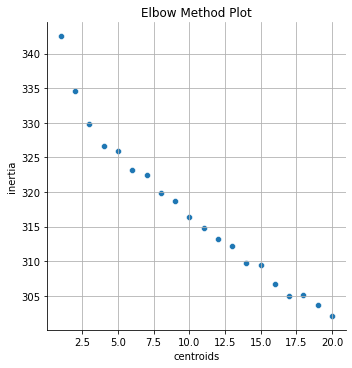

In [119]:
# 60/20/20 Train, Validate, Test split
train_val, test = train_test_split(df, stratify=df.type, test_size=.2, random_state=123)
train, validate = train_test_split(train_val, stratify=train_val.type, test_size=.25, random_state=123)

# Make the object
tfidf = TfidfVectorizer()
# Fit/Transform
X = tfidf.fit_transform(train.lemmatized)
run_kmeans(X, 20)

In [120]:
# Make the object
tfidf = TfidfVectorizer()
# Fit/Transform
X = tfidf.fit_transform(train.lemmatized)

cluster = KMeans(init = 'k-means++', n_clusters=8, n_init=15, random_state=123)
cluster.fit(X)
yhat = cluster.predict(X)
train['cluster'] = cluster.labels_
dummies = pd.get_dummies(train.cluster, prefix='clust')
train = pd.concat([train, dummies], axis=1)

# Transform
X = tfidf.transform(validate.lemmatized)

cluster = KMeans(init = 'k-means++', n_clusters=8, n_init=15, random_state=123)
cluster.fit(X)
yhat = cluster.predict(X)
validate['cluster'] = cluster.labels_
dummies = pd.get_dummies(validate.cluster, prefix='clust')
validate = pd.concat([validate, dummies], axis=1)

# Transform
X = tfidf.transform(test.lemmatized)

cluster = KMeans(init = 'k-means++', n_clusters=8, n_init=15, random_state=123)
cluster.fit(X)
yhat = cluster.predict(X)
test['cluster'] = cluster.labels_
dummies = pd.get_dummies(test.cluster, prefix='clust')
test = pd.concat([test, dummies], axis=1)

# Features
X_train = train[['clust_0', 'clust_1', 'clust_2', 'clust_3', 'clust_4', 'clust_5', 'clust_6', 'clust_7']]
# What we are predicting
y_train = train.type

# Features
X_validate = validate[['clust_0', 'clust_1', 'clust_2', 'clust_3', 'clust_4', 'clust_5', 'clust_6', 'clust_7']]
# What we are predicting
y_validate = validate.type

# Features
X_test = test[['clust_0', 'clust_1', 'clust_2', 'clust_3', 'clust_4', 'clust_5', 'clust_6', 'clust_7']]
# What we are predicting
y_test = test.type

# Make train and validate a dataframe
train = pd.DataFrame(dict(actual=y_train))
validate = pd.DataFrame(dict(actual=y_validate))
# Make the object and fit it
lm = LogisticRegression().fit(X_train, y_train)
# Make columns for the predictions
train['predicted_lm'] = lm.predict(X_train)
validate['predicted_lm'] = lm.predict(X_validate)
# Make the object and fit it
MNBclf = MultinomialNB()
MNBclf.fit(X_train, y_train)
# Make columns for the predictions
train['predicted_MNBclf'] = MNBclf.predict(X_train)
validate['predicted_MNBclf'] = MNBclf.predict(X_validate)


# Print out the results
print('Cluster Logistic Regression Train Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted_lm)))
print('-------------')
print('Cluster Logistic Regression Validate Accuracy: {:.2%}'.format(accuracy_score(validate.actual, validate.predicted_lm)))
print('-------------')
print('Cluster MultinomialNB Train Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted_MNBclf)))
print('-------------')
print('Cluster MultinomialNB Validate Accuracy: {:.2%}'.format(accuracy_score(validate.actual, validate.predicted_MNBclf)))
print('-------------')

Cluster Logistic Regression Train Accuracy: 18.94%
-------------
Cluster Logistic Regression Validate Accuracy: 15.00%
-------------
Cluster MultinomialNB Train Accuracy: 19.22%
-------------
Cluster MultinomialNB Validate Accuracy: 15.00%
-------------


___

## Both datasets

In [121]:
original = pd.read_csv('mbti_1.csv')
df0 = prepare_article(original)
df1 = pd.read_pickle('maindalemma.pkl')
df1['lemmatized'] = df1['stoped_lemma']
df1 = df1[['type', 'lemmatized']]
df1['lemmatized'] = df1['lemmatized'].apply(remove_stopwords)
df0 = df0[['type', 'lemmatized']]
df = pd.concat([df0, df1])
df['I_E'] = df['type'].astype(str).str[0]
df['N_S'] = df['type'].astype(str).str[1]
df['T_F'] = df['type'].astype(str).str[2]
df['J_P'] = df['type'].astype(str).str[3]
#applying the filter function to 'year_built' column 
df['personality_domain'] = df['type'].apply(filter)
df = df[['type', 'personality_domain', 'I_E', 'N_S', 'T_F', 'J_P', 'lemmatized']]
df.head()

type personality_domain I_E N_S T_F J_P  \
0  INFJ           Diplomat   I   N   F   J   
1  ENTP            Analyst   E   N   T   P   
2  INTP            Analyst   I   N   T   P   
3  INTJ            Analyst   I   N   T   J   
4  ENTJ            Analyst   E   N   T   J   

                                          lemmatized  
0  httpwwwyoutubecomwatchvqsxhcwekrwhttpmediatumb...  
1  finding lack post alarmingsex boring position ...  
2  httpswwwyoutubecomwatchvfhigbolffgwof course t...  
3  dear intp enjoyed conversation day esoteric ga...  
4  youre firedthats another silly misconception a...

In [122]:
# Make the object
tfidf = TfidfVectorizer()
# Fit/Transform
X = tfidf.fit_transform(df.lemmatized)
# What we are predicting
y = df.type
# Split X and y into train, validate, and test 
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, stratify=y, test_size=.2, random_state=123)
X_train, X_validate, y_train, y_validate = train_test_split(X_train_val, y_train_val, stratify=y_train_val, test_size=.25, random_state=123)
# Make train and validate a dataframe
train = pd.DataFrame(dict(actual=y_train))
validate = pd.DataFrame(dict(actual=y_validate))
# Make the object and fit it
lm = LogisticRegression().fit(X_train, y_train)
# Make columns for the predictions
train['predicted_lm'] = lm.predict(X_train)
validate['predicted_lm'] = lm.predict(X_validate)
# Make the object and fit it
MNBclf = MultinomialNB()
MNBclf.fit(X_train, y_train)
# Make columns for the predictions
train['predicted_MNBclf'] = MNBclf.predict(X_train)
validate['predicted_MNBclf'] = MNBclf.predict(X_validate)

# Make the object and fit/transform it
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df.lemmatized)
# Split X and y into train, validate, and test.
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, stratify=y, test_size=.2, random_state=123)
X_train, X_validate, y_train, y_validate = train_test_split(X_train_val, y_train_val, stratify=y_train_val, test_size=.25, random_state=123)
# Make the object and fit it
lm = LogisticRegression().fit(X_train, y_train)
# Make columns for the predictions
train['bow_predicted_lm'] = lm.predict(X_train)
validate['bow_predicted_lm'] = lm.predict(X_validate)
# Make the object and fit it
MNBclf = MultinomialNB()
MNBclf.fit(X_train, y_train)
# Make columns for the predictions
train['bow_predicted_MNBclf'] = MNBclf.predict(X_train)
validate['bow_predicted_MNBclf'] = MNBclf.predict(X_validate)

# Print out the results
print('Bag of Words Logistic Regression Train Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.bow_predicted_lm)))
print('-------------')
print('Bag of Words Logistic Regression Validate Accuracy: {:.2%}'.format(accuracy_score(validate.actual, validate.bow_predicted_lm)))
print('-------------')
print('Bag of Words MultinomialNB Train Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.bow_predicted_MNBclf)))
print('-------------')
print('Bag of Words MultinomialNB Validate Accuracy: {:.2%}'.format(accuracy_score(validate.actual, validate.bow_predicted_MNBclf)))
print('-------------')
print('TF-IDF MultinomialNB Train Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted_MNBclf)))
print('-------------')
print('TF-IDF MultinomialNB Validate Accuracy: {:.2%}'.format(accuracy_score(validate.actual, validate.predicted_MNBclf)))
print('-------------')
print('TF-IDF Logistic Regression Train Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted_lm)))
print('-------------')
print('TF-IDF Logistic Regression Validate Accuracy: {:.2%}'.format(accuracy_score(validate.actual, validate.predicted_lm)))
print('-------------')

Bag of Words Logistic Regression Train Accuracy: 100.00%
-------------
Bag of Words Logistic Regression Validate Accuracy: 58.11%
-------------
Bag of Words MultinomialNB Train Accuracy: 55.66%
-------------
Bag of Words MultinomialNB Validate Accuracy: 23.18%
-------------
TF-IDF MultinomialNB Train Accuracy: 20.38%
-------------
TF-IDF MultinomialNB Validate Accuracy: 19.89%
-------------
TF-IDF Logistic Regression Train Accuracy: 81.00%
-------------
TF-IDF Logistic Regression Validate Accuracy: 56.93%
-------------


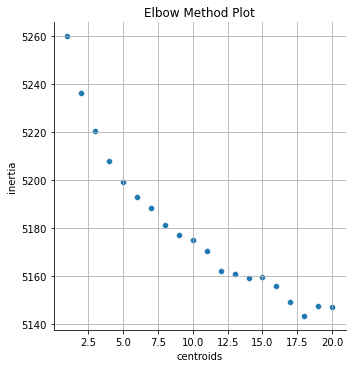

In [123]:
# 60/20/20 Train, Validate, Test split
train_val, test = train_test_split(df, stratify=df.type, test_size=.2, random_state=123)
train, validate = train_test_split(train_val, stratify=train_val.type, test_size=.25, random_state=123)

# Make the object
tfidf = TfidfVectorizer()
# Fit/Transform
X = tfidf.fit_transform(train.lemmatized)
run_kmeans(X, 20)

In [124]:
# Make the object
tfidf = TfidfVectorizer()
# Fit/Transform
X = tfidf.fit_transform(train.lemmatized)

cluster = KMeans(init = 'k-means++', n_clusters=8, n_init=15, random_state=123)
cluster.fit(X)
yhat = cluster.predict(X)
train['cluster'] = cluster.labels_
dummies = pd.get_dummies(train.cluster, prefix='clust')
train = pd.concat([train, dummies], axis=1)

# Transform
X = tfidf.transform(validate.lemmatized)

cluster = KMeans(init = 'k-means++', n_clusters=8, n_init=15, random_state=123)
cluster.fit(X)
yhat = cluster.predict(X)
validate['cluster'] = cluster.labels_
dummies = pd.get_dummies(validate.cluster, prefix='clust')
validate = pd.concat([validate, dummies], axis=1)

# Transform
X = tfidf.transform(test.lemmatized)

cluster = KMeans(init = 'k-means++', n_clusters=8, n_init=15, random_state=123)
cluster.fit(X)
yhat = cluster.predict(X)
test['cluster'] = cluster.labels_
dummies = pd.get_dummies(test.cluster, prefix='clust')
test = pd.concat([test, dummies], axis=1)

# Features
X_train = train[['clust_0', 'clust_1', 'clust_2', 'clust_3', 'clust_4', 'clust_5', 'clust_6', 'clust_7']]
# What we are predicting
y_train = train.type

# Features
X_validate = validate[['clust_0', 'clust_1', 'clust_2', 'clust_3', 'clust_4', 'clust_5', 'clust_6', 'clust_7']]
# What we are predicting
y_validate = validate.type

# Features
X_test = test[['clust_0', 'clust_1', 'clust_2', 'clust_3', 'clust_4', 'clust_5', 'clust_6', 'clust_7']]
# What we are predicting
y_test = test.type

# Make train and validate a dataframe
train = pd.DataFrame(dict(actual=y_train))
validate = pd.DataFrame(dict(actual=y_validate))
# Make the object and fit it
lm = LogisticRegression().fit(X_train, y_train)
# Make columns for the predictions
train['predicted_lm'] = lm.predict(X_train)
validate['predicted_lm'] = lm.predict(X_validate)
# Make the object and fit it
MNBclf = MultinomialNB()
MNBclf.fit(X_train, y_train)
# Make columns for the predictions
train['predicted_MNBclf'] = MNBclf.predict(X_train)
validate['predicted_MNBclf'] = MNBclf.predict(X_validate)


# Print out the results
print('Cluster Logistic Regression Train Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted_lm)))
print('-------------')
print('Cluster Logistic Regression Validate Accuracy: {:.2%}'.format(accuracy_score(validate.actual, validate.predicted_lm)))
print('-------------')
print('Cluster MultinomialNB Train Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted_MNBclf)))
print('-------------')
print('Cluster MultinomialNB Validate Accuracy: {:.2%}'.format(accuracy_score(validate.actual, validate.predicted_MNBclf)))
print('-------------')

Cluster Logistic Regression Train Accuracy: 29.65%
-------------
Cluster Logistic Regression Validate Accuracy: 11.21%
-------------
Cluster MultinomialNB Train Accuracy: 29.65%
-------------
Cluster MultinomialNB Validate Accuracy: 11.21%
-------------


## Testing custom module imports

In [125]:
df = pd.read_pickle('maindalemma.pkl')
df['lemmatized'] = df['stoped_lemma']
df = df[['type', 'lemmatized']]
df['lemmatized'] = df['lemmatized'].apply(remove_stopwords)
df['I_E'] = df['type'].astype(str).str[0]
df['N_S'] = df['type'].astype(str).str[1]
df['T_F'] = df['type'].astype(str).str[2]
df['J_P'] = df['type'].astype(str).str[3]
#applying the filter function to 'year_built' column 
df['personality_domain'] = df['type'].apply(filter)
df = df[['type', 'personality_domain', 'I_E', 'N_S', 'T_F', 'J_P', 'lemmatized']]

In [126]:
model.top_3_16_personalities(df)

Top Model per Feature
-------------
Bag of Words MultinomialNB Train Accuracy: 85.24%
-------------
Bag of Words MultinomialNB Validate Accuracy: 18.33%
-------------
TF-IDF MultinomialNB Train Accuracy: 25.91%
-------------
TF-IDF MultinomialNB Validate Accuracy: 17.50%
-------------


Top Clustering Model
-------------
Cluster MultinomialNB Train Accuracy: 19.22%
-------------
Cluster MultinomialNB Validate Accuracy: 15.00%
-------------
